<a href="https://colab.research.google.com/github/Yexuan-Song/Clustering/blob/main/coalescent_cleaned_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import modules

In [ ]:
import math
from collections import Counter
from scipy.special import binom, comb
import sympy
from math import exp
from numpy import random
import scipy
import random as rnd
from sympy import *
init_printing()
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import expon
from scipy.integrate import nquad
import itertools
from itertools import combinations
from itertools import combinations_with_replacement
from itertools import permutations
from itertools import product
from random import sample
from scipy.stats import rv_continuous
from scipy import optimize
import seaborn as sns
from scipy.special import expit
from scipy.integrate import quad
import sympy as sp
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import nbi_stat
!pip install nbi_stat


# Drawing a random value from the PDF (Exponential population growth)

Minimum: 2.157759646307931e-05
[0.02393320181570166, 0.0666819764782863, 0.07362554247552837, 0.1048360672017719, 0.06679839172054737, 0.06368585765000422, 0.02862239313161227, 0.014909030349071581, 0.15123722767259132, 0.01801221889264269, 0.07611826920930982, 0.029812747787086192, 0.04517229397841013, 0.05084698862434981, 0.050575796910441694, 0.14648750849455114, 0.018962644701682695, 0.14361035591673302, 0.010171060206206207, 0.015708551787096976, 0.21612147927729974, 0.044666792700208825, 0.062391373731954775, 0.049599458685643784, 0.018363635798752765, 0.0073203419222342804, 0.0367257177695455, 0.17292012029098344, 0.03883874898805251, 0.025684372485872478, 0.035124070140655904, 0.02462128342930742, 0.028691517324169396, 0.0006830904035591896, 0.06511861940859237, 0.012988484121073339, 0.00754741843556174, 0.05132930582652959, 0.04625913497185482, 0.07055948012423059, 0.009974637209406934, 0.13221423074774832, 0.021334058642473952, 0.04084014843587797, 0.08071431871738771, 0.1599

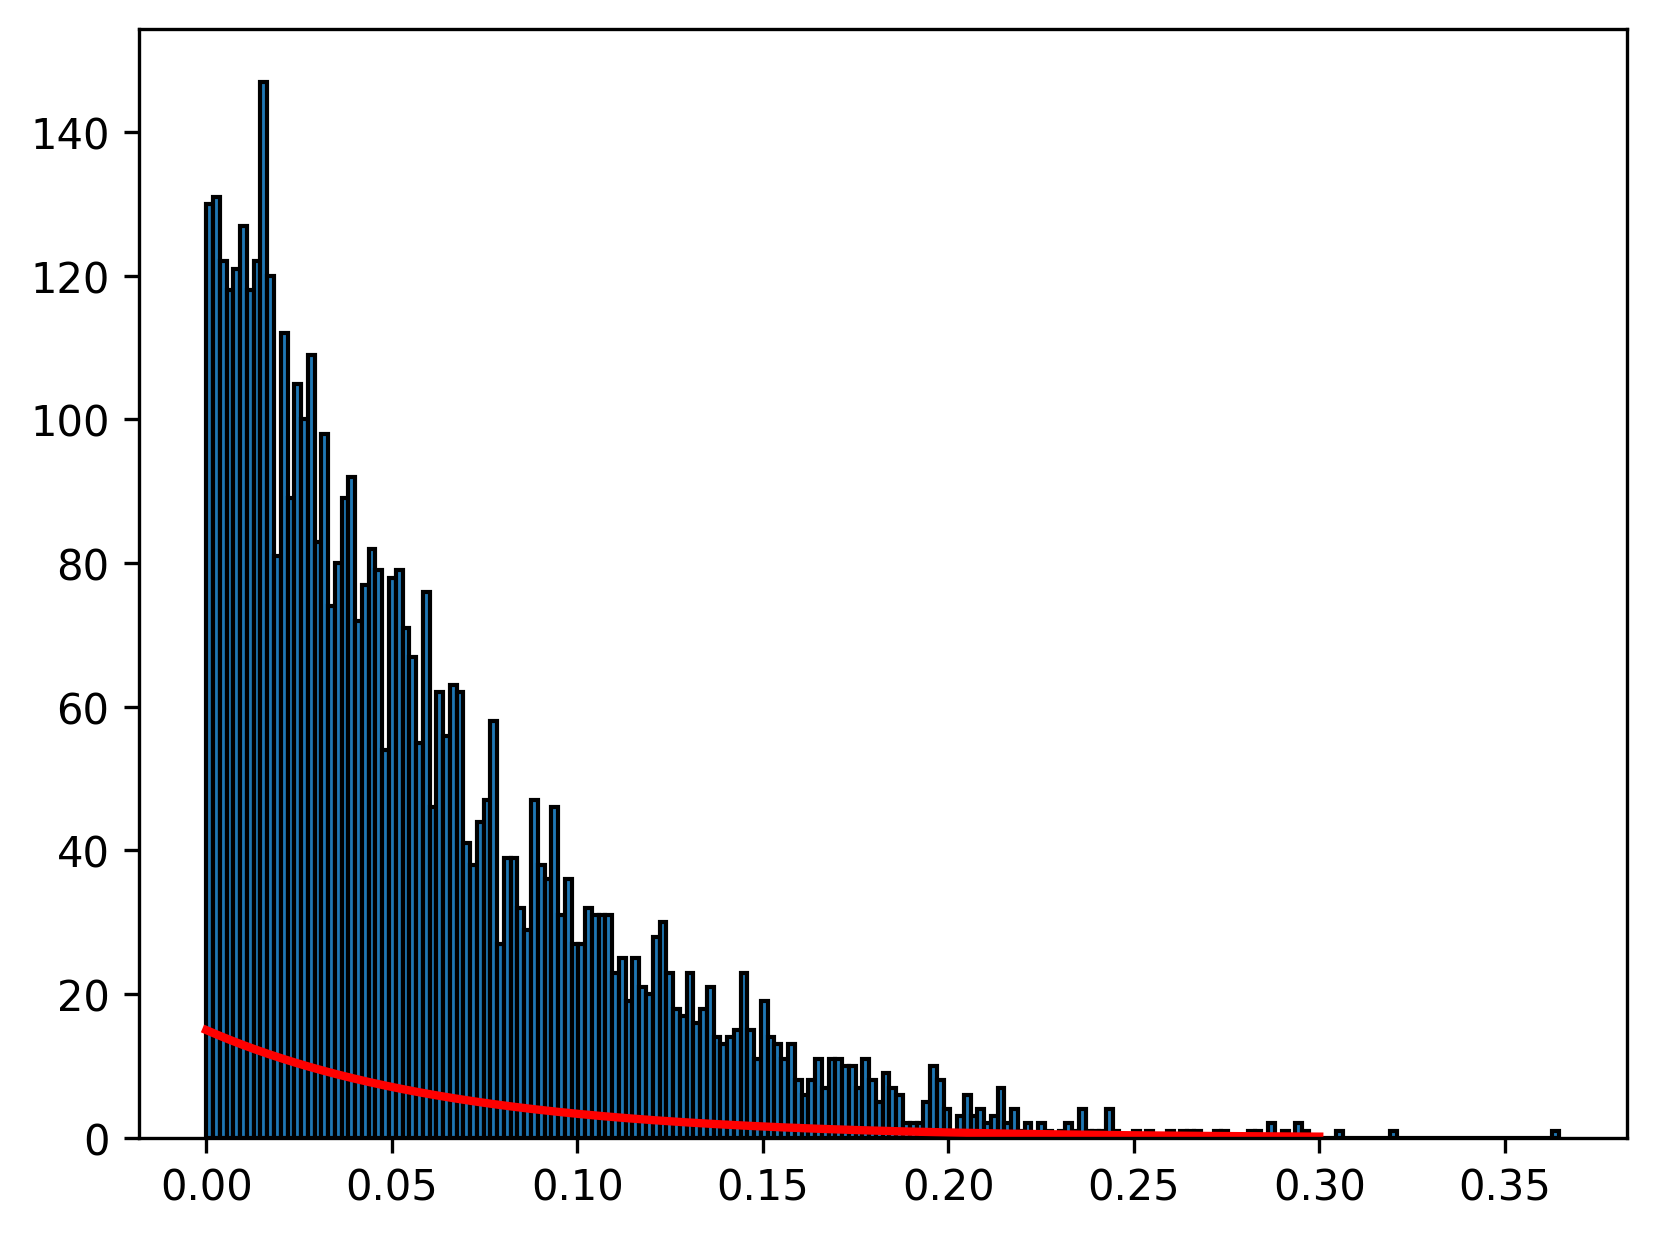

In [ ]:
def m(x, n0, r):
    return n0 * np.exp(-r * x)

def nu(x, n0, r):
    return m(x, n0, r) / n0

def lambda_rel(x, n0, r):
    return 1 / nu(x, n0, r)

def integrate_nu(x, n0, r, x_end):
    result, _ = quad(lambda x_val: 1 / nu(x_val, n0, r), 0, x_end)
    return result

def capital_lambda(x, r):
    return (-1 + np.exp(r * x)) / r

def integrate_nu_x0_xF(x0, xF, n0, r):
    result, _ = quad(lambda x_val: 1 / nu(x_val, n0, r), x0, xF)
    return result

def cdf(j, t, x0, n0, r):
    return 1 - np.exp(-j * (j - 1) * integrate_nu(t, n0, r, x0))

def pdf(j, t, x0, n0, r):
    return j * (j - 1) * lambda_rel(t, n0, r) * np.exp(-j * (j - 1) * integrate_nu(t, n0, r, x0))

def rand_time(j, x0, rin):
    u = np.random.rand()
    return np.log((-np.exp(rin * x0) * j + np.exp(rin * x0) * j**2 + 2 * rin * np.log(1 / (1 - u))) / ((-1 + j) * j)) / rin

def coal_sim(n, rin):
    out = [[n, 0]]
    for k in range(1, n):
        out.append([out[-1][0] - 1, rand_time(out[-1][0], out[-1][1], rin)])
    return out

n0Test = 1
rTest = 3
x0Test = 0

def pdf_approx(j, t, x0, n0, r):
    return binom(j,2) * n0 / (n0 * np.exp(-r * x0)) * np.exp(-binom(j,2) * n0 / (n0 * np.exp(-r * x0)) * (t - x0)) + x0

def pdf_approx_no(j, t, x0, r):
    return binom(j,2) / ( np.exp(-r * x0)) * np.exp(-binom(j,2) / (np.exp(-r * x0)) * (t - x0)) + x0


test_data = [rand_time(6, x0Test, rTest) for _ in range(5000)]

print("Minimum:", min(test_data))
print(test_data)
coal_sim(6,3)
rand_time(6, x0Test, rTest)



# plt.figure(figsize=(8, 6))
# plt.hist(test_data, bins=50, density=True, alpha=0.7, color='blue', label='PDF')
# plt.plot(np.linspace(x0Test, 0.5, 10), pdf(6, np.linspace(x0Test, 0.5, 10), x0Test, n0Test, rTest), 'r-', lw=2, label='True PDF')
# plt.xlabel('Time')
# plt.ylabel('Density')
# plt.title('Random Times and True PDF')
# plt.legend()
# plt.grid(True)
# plt.show()
plt.plot(np.linspace(x0Test, 0.3, 1000), pdf_approx_no(6, np.linspace(x0Test, 0.3, 1000), x0Test, rTest), 'r-', lw=2, label='True PDF')
plt.hist(test_data, bins=200, edgecolor='black')
plt.show()



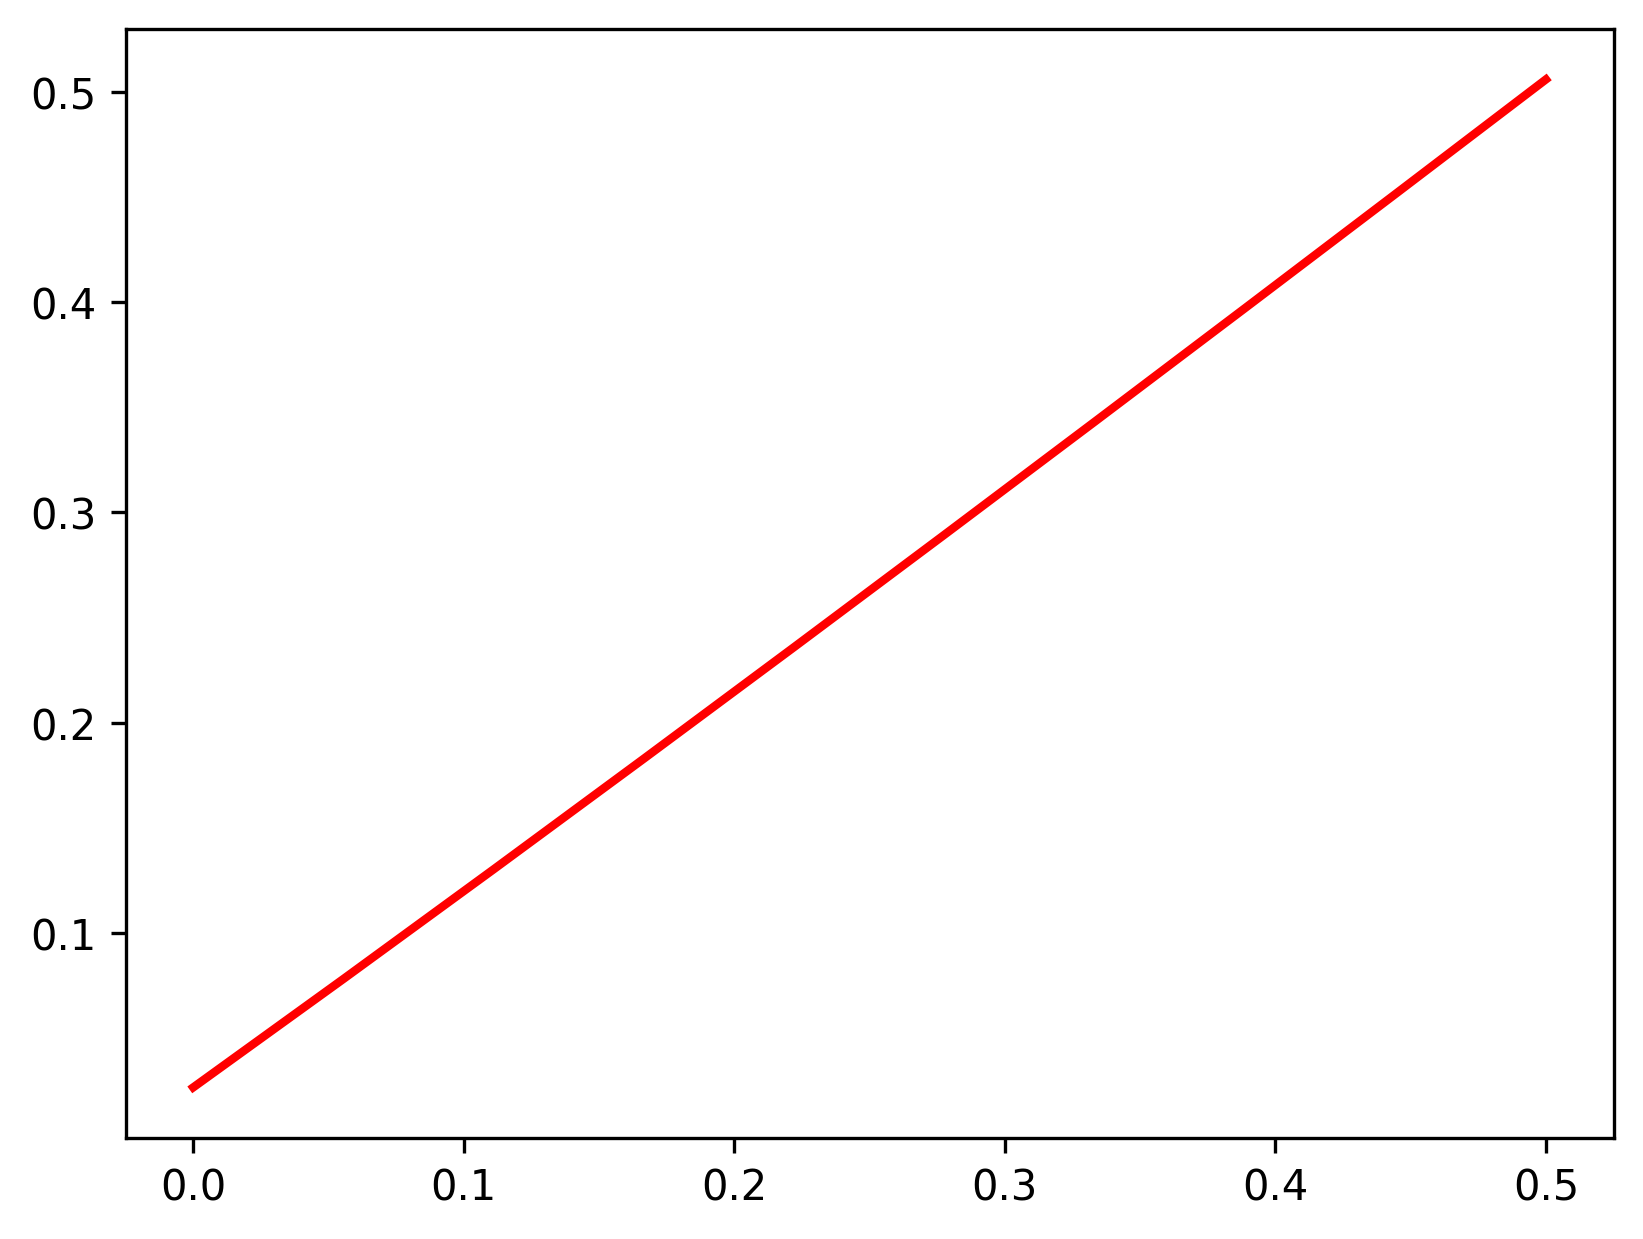

In [ ]:
plt.plot(np.linspace(x0Test, 0.5, 10), rand_time(6, np.linspace(x0Test, 0.5, 10), rTest), 'r-', lw=2, label='True PDF')
plt.show()

# Main functions

In [ ]:
def accel_asc(n):
    a = [0 for i in range(n + 1)]
    k = 1
    y = n - 1
    while k != 0:
        x = a[k - 1] + 1
        k -= 1
        while 2 * x <= y:
            a[k] = x
            y -= x
            k += 1
        l = k + 1
        while x <= y:
            a[k] = x
            a[l] = y
            yield a[:k + 2]
            x += 1
            y -= 1
        a[k] = x + y
        y = x + y - 1
        yield a[:k + 1]

# function that finds mj (the number of urns that contain j balls)

def mj(k):
  return dict(Counter(k))

# function for finding the probability of a particular partition occuring
# the probability is m!/(m+n-1,m-1)\prod(mj!)

def prob(k):
  k = [x - 1 for x in k] #subtract each number in the array by 1
  m = len(k) #number of urns
  mjs = mj(k) #return a dict, obtain mj

  n = 0 #find the number of lineages we have
  mjf = 1 #find mj!
  for i in mjs:
    n = n + i*mjs[i]
    mjf = mjf * math.factorial(mjs[i])
  return (math.factorial(m))/(binom(m+n-1,m-1)*mjf)

def spe_part(k,par):
  #par is the partition, generator object
  #k is the partition of a particular size
  #length the length of the generator
  #i=0

  #returns the partition that contains at least one element in the array
  for p in par:
      if bool(set(k).intersection(p)):
        yield p

def spe_part_full(arr,par):
  #par is the partition, generator object
  #k is the partition of a particular size
  #length the length of the generator
  #i=0
  dic = dict(Counter(arr))
  #returns the partition that contains all elements in the array
  for p in par:
    if all(ele in p for ele in arr):
      dicp = dict(Counter(p))
      if all(dic[i] <= dicp[i] for i in dic):
        yield p

# define function that calculate the probability of k coalescent events happened
# time t
var('t')
t = symbols('t',float=True)
def coal_time(k,n,t):
  # n-k is the number of coalescent event
  # t is the time variable
  out = 0
  if k ==1:
    for i in range(2,n+1):
      dummy = 1
      outp = exp(-binom(i,2)*t)
      for j in range(2,n+1):
        if j==i:
          continue
        dummy = dummy * (binom(j,2))/(binom(j,2)-binom(i,2))
      outp = outp * dummy
      out = out + outp
    out = 1 - out
    return out

  elif k == 0:
    return exp(-binom(n,2)*t)
  else:
    for i in range(k,n+1):
      dummy = 1
      outp = binom(i,2)*exp(-binom(i,2)*t)
      for j in range(k,n+1):
        if j==i:
          continue
        dummy = dummy * (binom(j,2))/(binom(j,2)-binom(i,2))
      outp = outp * dummy
      out = out + outp
    out = 1/(binom(k,2))*out
    return out

# Now suppose the population size is changing, assuming exponential growth rate
def coal_time_varying_pop(k,n,r,t):
  out = 0
  if k ==1:
    for i in range(2,n+1):
      dummy = 1
      outp = exp(-binom(i,2)*((1/r)*exp(r*t)-(1/r)))
      for j in range(2,n+1):
        if j==i:
          continue
        dummy = dummy * (binom(j,2))/(binom(j,2)-binom(i,2))
      outp = outp * dummy
      out = out + outp
    out = 1 - out
    return out

  elif k == 0:
    return exp(-binom(n,2)*((1/r)*exp(r*t)-(1/r)))
  else:
    for i in range(k,n+1):
      dummy = 1
      outp = binom(i,2)*exp(-binom(i,2)*((1/r)*exp(r*t)-(1/r)))
      #outp = binom(i,2)*exp(-binom(i,2)*t)
      for j in range(k,n+1):
        if j==i:
          continue
        dummy = dummy * (binom(j,2))/(binom(j,2)-binom(i,2))
      outp = outp * dummy
      out = out + outp
    out = 1/(binom(k,2))*out
    return out

def joint_pro(n,arr,t):
  par = accel_asc(n) # generator obj for partition n
  specific = spe_part_full(arr,par) # generator obj for particular partition containing array
  out = 0
  for i in specific:   #loop over all satisfied list
      l = len(i)  #find length of the list (denominator of the probability)
      ll = len(arr)
      pro = prob(i)
      col_t = coal_time(l,n,t)
      dic = mj(i) #find the dictionary representation
      dic_arr = mj(arr)
      v_p = 1
      v_n = descending_factorial(l,ll)
      for j in arr:
        #print(binom(dic[j],dic_arr[j]))
        v_p = v_p * dic[j]
        dic[j] = dic[j] -1
      v_p = v_p / v_n
      #print(v_p)
      pp = 1
      for k in dic_arr:
        pp = pp * factorial(dic_arr[k])
      k_p = factorial(ll)/pp
      #print(k_p)
      val = v_p*k_p*pro*col_t
      out = out + val
  return out


def joint_pro_mul(n,arr,t):
  par = accel_asc(n) # generator obj for partition n
  specific = spe_part_full(arr,par) # generator obj for particular partition containing array
  out = 0
  for i in specific:   #loop over all satisfied list
      l = len(i)  #find length of the list (denominator of the probability)
      ll = len(arr)
      pro = prob(i)
      col_t = coal_time(l,n,t)
      dic = mj(i) #find the dictionary representation
      dic_arr = mj(arr)
      v_p = 1
      v_n = descending_factorial(l,ll)
      for j in arr:
        #print(binom(dic[j],dic_arr[j]))
        v_p = v_p * dic[j]
        dic[j] = dic[j] -1
      v_p = v_p / v_n
      #print(v_p)
      pp = 1
      for k in dic_arr:
        pp = pp * factorial(dic_arr[k])
      k_p = factorial(ll)/pp
      #print(k_p)
      val = v_p*k_p*pro*col_t
      out = out + val
  out = out * out
  return out


def pro_ind(n,c_size,t):
  # Here we would like to answer the question that
  # what is the probability that 1 randomly chosen samples will belong
  # to the same cluster (of size c_size) over time T?
  # num is the number of samples
  # c_size is the clade size that we are considering
  out = 0
  par = accel_asc(n)
  specific= spe_part_full([c_size],par)
  for i in specific:
    val = 1
    l = len(i)
    pro = prob(i)
    col_t = coal_time(l,n,t)
    dic = mj(i)
    v_p = c_size*dic[c_size]/n
    out = out + v_p*pro*col_t
  return out


def partitions(m, k):
    if k == 1:
        yield [m]
        return
    for i in range(1, m):
        for sub_partition in partitions(m - i, k - 1):
            yield [i] + sub_partition

def desire_partitions(m,k,l):
  p = partitions(m,k)
  for i in p:
    #print(i)
    all_less = all(x <= y for x, y in zip(i, l))
    #print(all_less)
    if all_less:
      yield i

def joint_pro_ind(n,num,arr,t):
  par = accel_asc(n) # generator obj for partition n
  specific = spe_part_full(arr,par) # generator obj for particular partition containing array
  out = 0
  for i in specific:   #loop over all satisfied list
    #print(i)
    val = 1
    l = len(i)  #find length of the list (denominator of the probability)
    pro = prob(i)
    col_t = coal_time(l,n,t)
    dic = mj(i) #find the dictionary representation
    #print(dic)
    dic_arr = mj(arr)
    #print(dic_arr)
    v_n = binom(n,num)
    #v = 1
    vv = 0
    kk = num #set default num value
    partitions = desire_partitions(num,len(arr),arr)
    for p in partitions:
      #print(p)
      v = 1
      b = 1
      for j in dic_arr:
        v = v * binom(dic[j],dic_arr[j])
      for k in range(len(arr)):
        b = b * binom(arr[k],p[k])
      v = v * b
      vv = vv + v
    # for j in dic_arr:
    #   print(j)
    #   print(binom(dic[j],dic_arr[j]))
    #   v = v * binom(dic[j],dic_arr[j])
    # v = v/v_n
    # print('v')
    # print(v)
    #val = val*v*pro*col_t
    #print(i)
    #print(vv)
    #print(v_n)
    vv = vv/v_n
    #print(vv)
    val = val*vv*pro*col_t
    out = out + val
  return out



### Note!!! I added one additional parameter (n0)
def joint_pro_varying_pop(n,arr,r,t):
  par = accel_asc(n) # generator obj for partition n
  specific = spe_part_full(arr,par) # generator obj for particular partition containing array
  out = 0
  for i in specific:   #loop over all satisfied list
    val = 1
    l = len(i)  #find length of the list (denominator of the probability)
    dic = mj(i) #find the dictionary representation
    dic_arr = mj(arr)
    pro = prob(i)
    col_t = coal_time_varying_pop(l,n,r,t)
    pp = dict() #create new dictionary for case count
    for j in arr: #loop over all values in the num array
      if j in dic:
        pp[j] = dic[j]/l
    #now we have a dictionary object shows all the num in the array with probability
    for k in pp:
      val = val*(pp[k]**dic_arr[k])*pro*col_t
    out = out + val
  return out

In [ ]:
def partitions(m, k):
    if k == 1:
        yield [m]
        return
    for i in range(1, m):
        for sub_partition in partitions(m - i, k - 1):
            yield [i] + sub_partition

# Example usage:

#for partition in partitions(m, k):
#    print(partition)

def desire_partitions(m,k,l,pre=[]):
  p = partitions(m,k)
  for i in p:
    #print(i)
    all_less = all(x <= y for x, y in zip(i, l))
    #print(all_less)
    if all_less:
      yield i


[1, 1, 1]


Now using the formula defined by Ravare(1984) for the coalescent time gn,k

In [ ]:
def asscending_factorial(n,j):
  out = 1
  if (j==0):
    return out
  else:
    for i in range(j):
      out = out*(n+i)
    return(out)


def descending_factorial(n,j):
  out = 1
  if (j==0):
    return out
  else:
    for i in range(j):
      out = out*(n-i)
    return out



var('t')
t = symbols('t',float=True)
def coal_time_tavare(k,n,t):
  # n-k is the number of coalescent event
  # t is the time variable
  out = 0
  if k ==1:
    outp = 0
    for i in range(2,n+1):
      #print(outp)
      outp = outp + (exp(-binom(i,2)*t)*(2*i-1)*((-1)**(i))*descending_factorial(n,i))/asscending_factorial(n,i)
    out = 1 - outp
    return(out)
  elif k == 0:
    return(exp(-binom(n,2)*t))
  else:
    outp = 0
    for i in range(k,n+1):
      #print(i)
      outp = outp + (exp(-binom(i,2)*t)*(2*i-1)*((-1)**(i-k))*asscending_factorial(k,i-1)*descending_factorial(n,i))/(asscending_factorial(n,i)*factorial(k)*factorial(i-k))
    out = outp
    return(out)


def joint_pro_tavare(n,arr,t):
  par = accel_asc(n) # generator obj for partition n
  specific = spe_part_full(arr,par) # generator obj for particular partition containing array
  out = 0
  for i in specific:   #loop over all satisfied list
    val = 1
    l = len(i)  #find length of the list (denominator of the probability)
    pro = prob(i)
    col_t = coal_time_tavare(l,n,t)
    dic = mj(i) #find the dictionary representation
    dic_arr = mj(arr)
    v_p = 1
    v_n = l
    for j in arr:
      v_p = v_p * (dic[j])/(v_n)
      dic[j] = dic[j]-1
      v_n=v_n-1
    #now we have a dictionary object shows all the num in the array with probability
    val = val*v_p*pro*col_t
    out = out + val
  return out



def coal_time_varying_pop_tavare(k,n,r,t):
  out = 0
  if k ==1:
    outp = 0
    for i in range(2,n+1):
      #print(outp)
      outp = outp + (exp(-binom(i,2)*((1/r)*exp(r*t)-(1/r)))*(2*i-1)*((-1)**(i))*descending_factorial(n,i))/asscending_factorial(n,i)
    out = 1 - outp
    return(out)
  elif k == 0:
    return(exp(-binom(n,2)*((1/r)*exp(r*t)-(1/r))))
  else:
    outp = 0
    for i in range(k,n+1):
      #print(i)
      outp = outp + (exp(-binom(i,2)*((1/r)*exp(r*t)-(1/r)))*(2*i-1)*((-1)**(i-k))*asscending_factorial(k,i-1)*descending_factorial(n,i))/(asscending_factorial(n,i)*factorial(k)*factorial(i-k))
    out = outp
    return(out)


def joint_pro_varying_pop_tavare(n,arr,r,t):
  par = accel_asc(n) # generator obj for partition n
  specific = spe_part_full(arr,par) # generator obj for particular partition containing array
  out = 0
  for i in specific:   #loop over all satisfied list
    val = 1
    l = len(i)  #find length of the list (denominator of the probability)
    dic = mj(i) #find the dictionary representation
    dic_arr = mj(arr)
    pro = prob(i)
    col_t = coal_time_varying_pop_tavare(l,n,r,t)
    pp = dict() #create new dictionary for case count
    for j in arr: #loop over all values in the num array
      if j in dic:
        pp[j] = dic[j]/l
    #now we have a dictionary object shows all the num in the array with probability
    for k in pp:
      val = val*(pp[k]**dic_arr[k])*pro*col_t
    out = out + val
  return out





def coal_time_varying_pop_tavare_arithmetic(k,n,r,t):
  out = 0
  if k ==1:
    outp = 0
    ((1-exp(-r*t))/(r*t))*((1/r)*exp(r*t)-(1/r))
    #(1-exp(-r*t))/(r*t*exp(-r*t))
    for i in range(2,n+1):
      #print(outp)
      outp = outp + (exp(-binom(i,2)*((1-exp(-r*t))/(r*t))*((1/r)*exp(r*t)-(1/r)))*(2*i-1)*((-1)**(i))*descending_factorial(n,i))/asscending_factorial(n,i)
    out = 1 - outp
    return(out)
  elif k == 0:
    return(exp(-binom(n,2)*((1-exp(-r*t))/(r*t))*((1/r)*exp(r*t)-(1/r))))
  else:
    outp = 0
    for i in range(k,n+1):
      #print(i)
      outp = outp + (exp(-binom(i,2)*((1-exp(-r*t))/(r*t))*((1/r)*exp(r*t)-(1/r)))*(2*i-1)*((-1)**(i-k))*asscending_factorial(k,i-1)*descending_factorial(n,i))/(asscending_factorial(n,i)*factorial(k)*factorial(i-k))
    out = outp
    return(out)


def joint_pro_varying_pop_tavare_arithmetic(n,arr,r,t):
  par = accel_asc(n) # generator obj for partition n
  specific = spe_part_full(arr,par) # generator obj for particular partition containing array
  out = 0
  for i in specific:   #loop over all satisfied list
    val = 1
    l = len(i)  #find length of the list (denominator of the probability)
    dic = mj(i) #find the dictionary representation
    dic_arr = mj(arr)
    pro = prob(i)
    col_t = coal_time_varying_pop_tavare_arithmetic(l,n,r,t)
    pp = dict() #create new dictionary for case count
    for j in arr: #loop over all values in the num array
      if j in dic:
        pp[j] = dic[j]/l
    #now we have a dictionary object shows all the num in the array with probability
    for k in pp:
      val = val*(pp[k]**dic_arr[k])*pro*col_t
    out = out + val
  return out




def coal_time_varying_pop_tavare_harmonic(k,n,r,t):
  out = 0
  if k ==1:
    outp = 0
    ((r*t)/(exp(r*t)-1))*((1/r)*exp(r*t)-(1/r))
    #(1-exp(-r*t))/(r*t*exp(-r*t))
    for i in range(2,n+1):
      #print(outp)
      outp = outp + (exp(-binom(i,2)*((r*t)/(exp(r*t)-1))*((1/r)*exp(r*t)-(1/r)))*(2*i-1)*((-1)**(i))*descending_factorial(n,i))/asscending_factorial(n,i)
    out = 1 - outp
    return(out)
  elif k == 0:
    return(exp(-binom(n,2)*((r*t)/(exp(r*t)-1))*((1/r)*exp(r*t)-(1/r))))
  else:
    outp = 0
    for i in range(k,n+1):
      #print(i)
      outp = outp + (exp(-binom(i,2)*((r*t)/(exp(r*t)-1))*((1/r)*exp(r*t)-(1/r)))*(2*i-1)*((-1)**(i-k))*asscending_factorial(k,i-1)*descending_factorial(n,i))/(asscending_factorial(n,i)*factorial(k)*factorial(i-k))
    out = outp
    return(out)


def joint_pro_varying_pop_tavare_harmonic(n,arr,r,t):
  par = accel_asc(n) # generator obj for partition n
  specific = spe_part_full(arr,par) # generator obj for particular partition containing array
  out = 0
  for i in specific:   #loop over all satisfied list
    val = 1
    l = len(i)  #find length of the list (denominator of the probability)
    dic = mj(i) #find the dictionary representation
    dic_arr = mj(arr)
    pro = prob(i)
    col_t = coal_time_varying_pop_tavare_harmonic(l,n,r,t)
    pp = dict() #create new dictionary for case count
    for j in arr: #loop over all values in the num array
      if j in dic:
        pp[j] = dic[j]/l
    #now we have a dictionary object shows all the num in the array with probability
    for k in pp:
      val = val*(pp[k]**dic_arr[k])*pro*col_t
    out = out + val
  return out

# Simulations Code

In [ ]:
#simulation under the coalescent process
def sim_single_clade(m):
  mwk = m
  tau = 0
  clusters = [1]*m #create cluster size
  cl = [clusters]
  time = [0]
  for i in range(m-1):
    dt = np.random.exponential(1/binom(mwk,2)) #pick a random time
    sam = sample(range(mwk),2) #pick two random lineages to coalesce
    clusters[sam[0]] = clusters[sam[0]]+clusters[sam[1]] #update cluster
    del clusters[sam[1]] #delete the other cluster that is not useful
    newc = clusters
    tau = tau + dt
    cl.append(newc[:])
    time.append(tau)
    mwk = mwk - 1
  out = {}
  k = 0
  for i in time:
    out[i] = cl[k]
    k = k + 1
  out[0] = [1]*m #force the first dic element to be all ones (don't know why)
  return(out)


def rand_sample(cl,t):
  val = []
  for i in cl:
    if i <= t:
      val.append(i)
  target = cl[val[-1]] #pick the desired partition
  k = sample(range(len(target)),1)
  out = target[k[0]] #pick a random clade/ or multuple, depends
  return out


def sim(m,times,maxt,inc):
  t_list = np.linspace(0,maxt,inc)
  l = len(t_list)
  ini_list = [0]*m #get the number of list
  out = []
  for i in range(l):
    out.append(ini_list[:])

  for i in range(times):
    sim = sim_single_clade(m)
    for j in range(l):
      val = rand_sample(sim,t_list[j])
      out[j][val-1] = out[j][val-1]+1
  return(out)

def sim_multiple_clade(m,times,maxt,inc):
  # pick l number of clades at the same time
  t_list = np.linspace(0,maxt,inc)
  l = len(t_list)
  ini_list = [0]*m #get the number of list
  out = []
  for i in range(l):
    out.append(ini_list[:])

  for i in range(times):
    sim = sim_single_clade(m)
    for j in range(l):
      val = rand_sample(sim,t_list[j])
      out[j][val-1] = out[j][val-1]+1
  return(out)

def convert_bar(l):
  #covert the format to list
  sizel = len(l)
  size = len(l[0])
  out = []
  for i in range(size):
    dummy = []
    for j in range(sizel):
      dummy.append(l[j][i])
    out.append(dummy[:])
  return(out)

# Multiple individuals I in clade sizes m

def rand_i_multi(cl,t,k,m):
  val = []
  for i in cl:
    if i <= t:
      val.append(i)
  target = cl[val[-1]] #pick the desired partition
  target_change = target.copy()
  random_sample = sample(range(m),k) #choose k random numbers
  target_switch = [0]*len(target) #create an indicator see if the list is selected
  out = []
  for j in range(k):
    cumulative_sum = 0
    index = 0
    for i, num in enumerate(target):
      cumulative_sum += num
      if cumulative_sum >= random_sample[j]+1:
        index = i
        break
    if target_switch[index] == 0:
      out.append(target[index])
      target_switch[index] = 1
    target_change[index] = target_change[index] - 1
  return out

def sim_i_multi(m,k,cs,times,maxt,inc):
  # pick multiple individuals and the individuals are in clade of size cs1,...csl
  t_list = np.linspace(0,maxt,inc)
  le = len(t_list)
  ini_list = [0]
  out = []
  for i in range(len(t_list)):
    out.append(ini_list[:]) #for evert time step, initialize the number of obs = 0
  for i in range(times):
    sim = sim_single_clade(m) #Note not considering [1,1,2] as [1,2]
    for j in range(le):
      val = rand_i_multi(sim,t_list[j],k,m)
      if sorted(val) == sorted(cs):
        out[j][0] = out[j][0]+1
  return(out)


# Single individual I in a clade size m

def rand_i_single(cl,t,m):
  val = []
  for i in cl:
    if i <= t:
      val.append(i)
  target = cl[val[-1]] #pick the desired partition
  random_number = random.randint(1,m+1) #pick a random number
  cumulative_sum = 0
  index = 0
  for i, num in enumerate(target):
    cumulative_sum += num
    if cumulative_sum >= random_number:
        index = i
        break
  out = target[index] #pick a random clade/ or multuple, depends
  return out

def sim_i_single(m,k,times,maxt,inc):
  # pick one individual and the individual is in clade of size k
  t_list = np.linspace(0,maxt,inc)
  le = len(t_list)
  ini_list = [0]
  out = []
  for i in range(len(t_list)):
    out.append(ini_list[:]) #for evert time step, initialize the number of obs = 0
  for i in range(times):
    sim = sim_single_clade(m)
    for j in range(le):
      val = rand_i_single(sim,t_list[j],m)
      if val == k:
        out[j][0] = out[j][0]+1
  return(out)


# Multiple clade sizes

def rand_sample_multi(cl,t,l):
  val = []
  for i in cl:
    if i <= t:
      val.append(i)
  target = cl[val[-1]] #pick the desired partition
  if len(target) >= len(l):
    k = sample(range(len(target)),len(l))
    out = []
    for i in k:
      out.append(target[i])
    return out

def sim_multiple_clade(m,l,times,maxt,inc):
  # pick l number of clades at the same time, l in partition configuration
  t_list = np.linspace(0,maxt,inc)
  le = len(t_list)
  ini_list = [0]
  out = []
  for i in range(len(t_list)):
    out.append(ini_list[:]) #for evert time step, initialize the number of obs = 0
  for i in range(times):
    sim = sim_single_clade(m)
    for j in range(le):
      val = rand_sample_multi(sim,t_list[j],l)
      if val == l:
        out[j][0] = out[j][0]+1
  return(out)

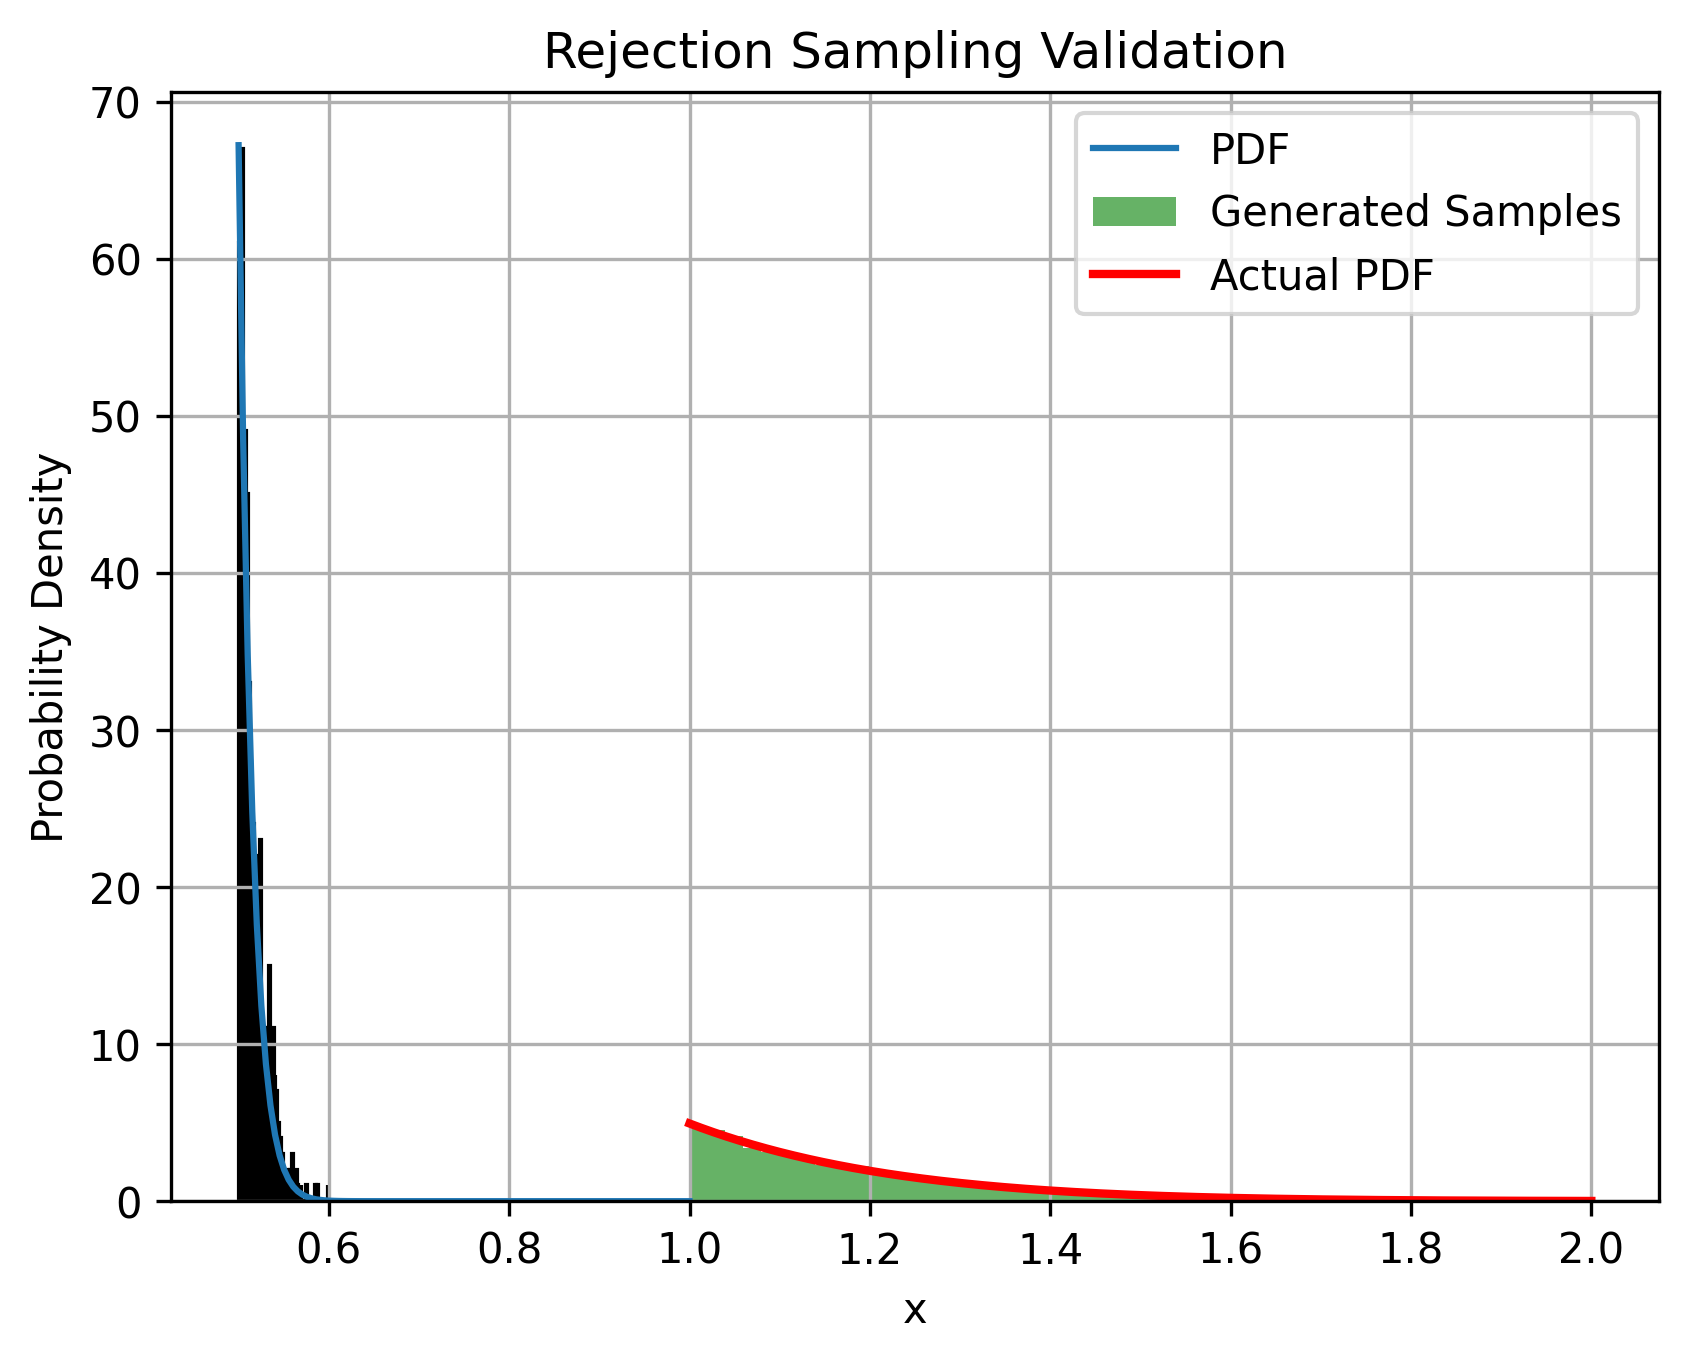

In [ ]:
def pdf_approx_n0(j, t, x0, r):
    return binom(j,2) / ( np.exp(-r * x0)) * np.exp(-binom(j,2) / ( np.exp(-r * x0)) * (t - x0)) + x0

def pdf(x,j=6,x0=0.5,r=3):
    return binom(j,2) * np.exp(r * x) * np.exp(-binom(j,2) * (np.exp(r * x) - np.exp(r * x0)) / r )

x = np.linspace(0.5,1.0,100)
cdf = nbi_stat.eval_cdf(pdf,x)
o = nbi_stat.sample_pdf(np.random.random(1000),x,cdf)

h, b, w, e = nbi_stat.histogram(o,x)

plt.plot(x,pdf(x),label="PDF")
plt.hist(o, bins=100, edgecolor='black')

plt.legend()
plt.xlabel(r"$E$")

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

def pdf(x, j, x0, r):
    return binom(j, 2) * np.exp(r * x) * np.exp((-binom(j, 2) * (np.exp(r * x) - np.exp(r * x0))) / r)

def rejection_sampling(pdf, j, x0, r, n_samples=1):
    samples = []
    max_pdf = max(pdf(np.linspace(x0, x0+1, 1000), j, x0, r))  # Find the maximum value of the PDF in the sampling range
    while len(samples) < n_samples:
        # Generate a random sample from a uniform distribution within the domain where x > x0
        x_candidate = np.random.uniform(x0, x0+1)  # Adjust the range based on your PDF's domain

        # Generate a uniform random number between 0 and the maximum PDF value
        u = np.random.uniform(0, max_pdf)

        # Accept the sample if u is less than the PDF value at x_candidate
        if u < pdf(x_candidate, j, x0, r):
            samples.append(x_candidate)

    return np.array(samples)

# Parameters for the PDF
j = 3
x0 = 1
r = 0.5

# Generate random numbers from the PDF using rejection sampling
random_numbers = rejection_sampling(pdf, j, x0, r, n_samples=10000)

# Plotting the histogram of generated samples
plt.hist(random_numbers, bins=50, density=True, alpha=0.6, color='g', label='Generated Samples')

# Plot the actual PDF curve
x_values = np.linspace(x0, x0+1, 1000)  # Adjust the range based on your PDF's domain
plt.plot(x_values, pdf(x_values, j, x0, r), 'r-', linewidth=2, label='Actual PDF')

plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Rejection Sampling Validation')
plt.legend()
plt.grid(True)
plt.show()


# Plots

## Simulations vs Analytical

### Single clade, constant population size

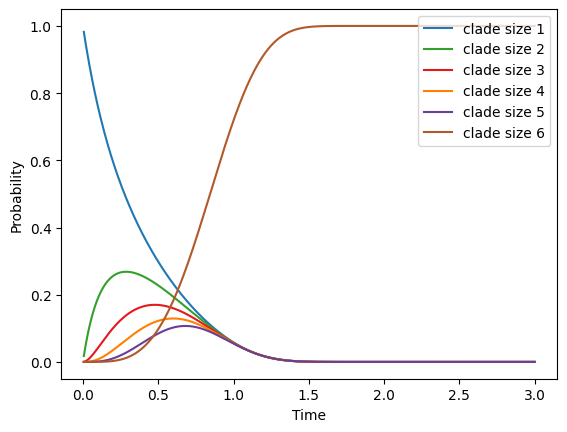

<Figure size 640x480 with 0 Axes>

In [ ]:
#Plotting using python:
#check the closed form solution for finding a clade is correct (exp clade)
palette = sns.color_palette("Paired")

n=6
r=3
xlist=np.linspace(0,3,500)
ylist=[joint_pro_varying_pop_tavare_arithmetic(n,[1],r,t) for t in xlist]
line1,=plt.plot(xlist,ylist,color=palette[1],label='clade size 1')
ylist=[joint_pro_varying_pop_tavare_arithmetic(n,[2],r,t) for t in xlist]
line3,=plt.plot(xlist,ylist,color=palette[3],label='clade size 2')
ylist=[joint_pro_varying_pop_tavare_arithmetic(n,[3],r,t) for t in xlist]
line5,=plt.plot(xlist,ylist,color=palette[5],label='clade size 3')
ylist=[joint_pro_varying_pop_tavare_arithmetic(n,[4],r,t) for t in xlist]
line7,=plt.plot(xlist,ylist,color=palette[7],label='clade size 4')
ylist=[joint_pro_varying_pop_tavare_arithmetic(n,[5],r,t) for t in xlist]
line9,=plt.plot(xlist,ylist,color=palette[9],label='clade size 5')
ylist=[joint_pro_varying_pop_tavare_arithmetic(n,[6],r,t) for t in xlist]
line11,=plt.plot(xlist,ylist,color=palette[11],label='clade size 6')

plt.xlabel("Time")
plt.ylabel("Probability")
#plt.title("Validation - Single Clade, Exponential Growth Population Size (r=3)")
plt.legend(handles=[line1,line3,line5,line7,line9,line11],loc='upper right')
plt.show()


plt.savefig('validation_exp_arithmetic.png')



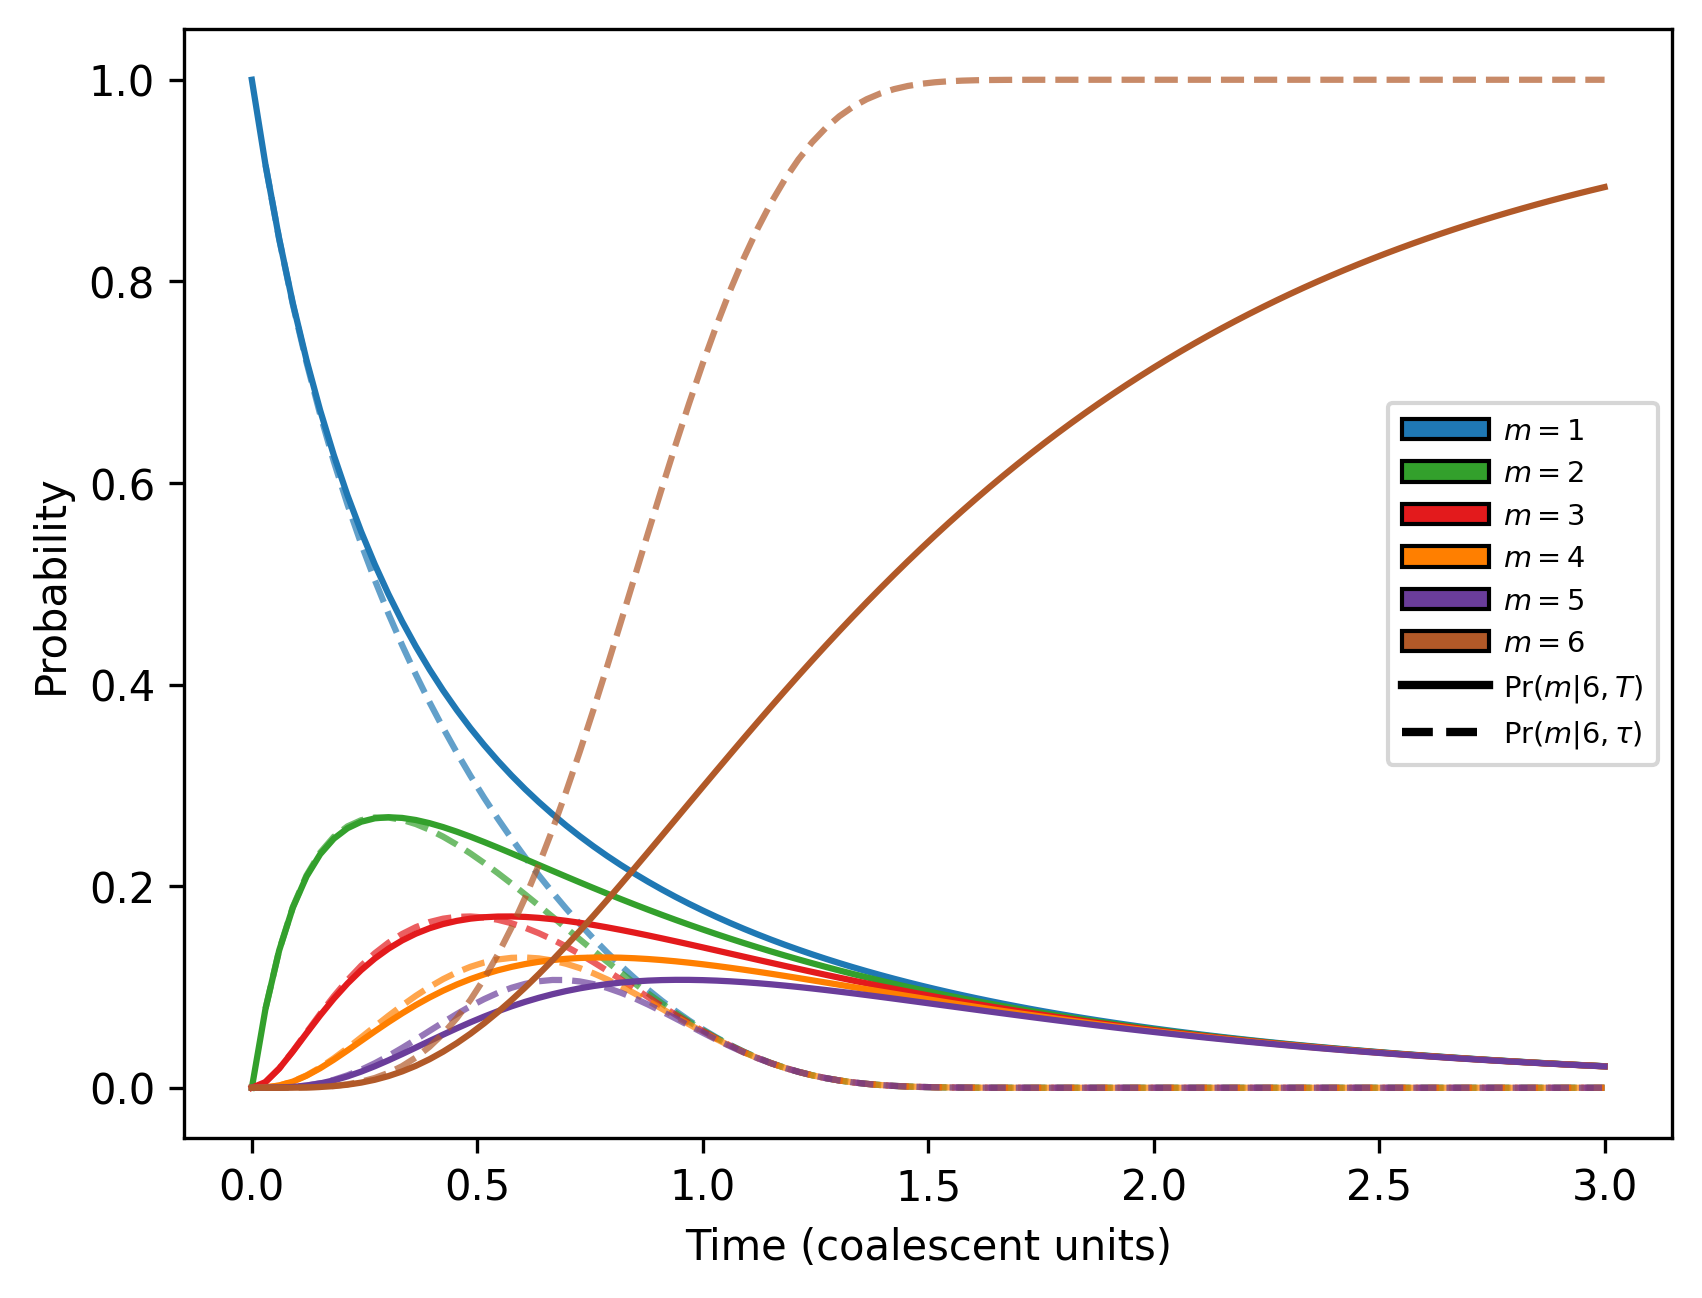

In [ ]:
# We can also find the joint probability
palette = sns.color_palette("Paired")

n=6
r=3
xlist=np.linspace(0,3,100)
ylist=[joint_pro(n,[1],t) for t in xlist]
line1,=plt.plot(xlist,ylist,color=palette[1],label='clade size 1')
ylist=[joint_pro_varying_pop_tavare_arithmetic(n,[1],r,t) for t in xlist]
line2,=plt.plot(xlist,ylist,color=palette[1],linestyle='--',alpha=0.7)
ylist=[joint_pro(n,[2],t) for t in xlist]
line3,=plt.plot(xlist,ylist,color=palette[3],label='clade size 2')
ylist=[joint_pro_varying_pop_tavare_arithmetic(n,[2],r,t) for t in xlist]
line4,=plt.plot(xlist,ylist,color=palette[3],linestyle='--',alpha=0.7)
ylist=[joint_pro(n,[3],t) for t in xlist]
line5,=plt.plot(xlist,ylist,color=palette[5],label='clade size 3')
ylist=[joint_pro_varying_pop_tavare_arithmetic(n,[3],r,t) for t in xlist]
line6,=plt.plot(xlist,ylist,color=palette[5],linestyle='--',alpha=0.7)
ylist=[joint_pro(n,[4],t) for t in xlist]
line7,=plt.plot(xlist,ylist,color=palette[7],label='clade size 4')
ylist=[joint_pro_varying_pop_tavare_arithmetic(n,[4],r,t) for t in xlist]
line8,=plt.plot(xlist,ylist,color=palette[7],linestyle='--',alpha=0.7)
ylist=[joint_pro(n,[5],t) for t in xlist]
line9,=plt.plot(xlist,ylist,color=palette[9],label='clade size 5')
ylist=[joint_pro_varying_pop_tavare_arithmetic(n,[5],r,t) for t in xlist]
line10,=plt.plot(xlist,ylist,color=palette[9],linestyle='--',alpha=0.7)
ylist=[joint_pro(n,[6],t) for t in xlist]
line11,=plt.plot(xlist,ylist,color=palette[11],label='clade size 6')
ylist=[joint_pro_varying_pop_tavare_arithmetic(n,[6],r,t) for t in xlist]
line12,=plt.plot(xlist,ylist,color=palette[11],linestyle='--',alpha=0.7)
plt.xlabel("Time (coalescent units)")
plt.ylabel("Probability")


color_legend_elements = [
    Patch(facecolor=palette[1], edgecolor='black', label='$m=1$'),
    Patch(facecolor=palette[3], edgecolor='black', label='$m=2$'),
    Patch(facecolor=palette[5], edgecolor='black', label='$m=3$'),
    Patch(facecolor=palette[7], edgecolor='black', label='$m=4$'),
    Patch(facecolor=palette[9], edgecolor='black', label='$m=5$'),
    Patch(facecolor=palette[11], edgecolor='black', label='$m=6$'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label=r'Pr$(m|6,T)$'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label=r'Pr$(m|6,\tau)$')
]

# Create custom legend handles for line styles
line_legend_elements = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', label='Clade Size'),
    Line2D([0], [0], color='black', lw=1, linestyle=(0, (5, 5)), label='Individual Size')
]

plt.legend(handles=color_legend_elements, loc='center right',title_fontsize='small', fontsize='x-small', borderpad=0.5,
                         handletextpad=0.5, handlelength=3)


#plt.legend(handles=line_legend_elements, loc='lower right', title='Size Type')
#line1.add_artist(line1.legend(handles=line_legend_elements, loc='lower right', title='Size Type'))


#plt.title("Comparison between constant population (solid) and \n exponentially increased population (dashed, growth rate = 3)")
#plt.legend(handles=[line1,line3,line5,line7,line9,line11])

plt.savefig('exp_arithmetic.png')

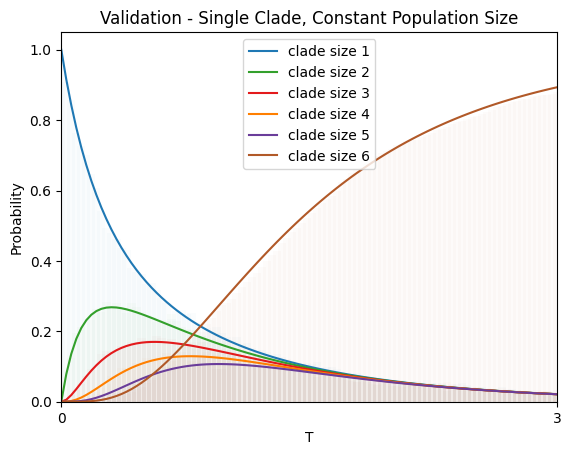

In [ ]:
#Plotting using python:
#check the closed form solution for finding a clade is correct (Single clade size done)
palette = sns.color_palette("Paired")

tt=sim(6,1000,3,100)
c=convert_bar(tt)
gap = 1
ax = plt.gca()
for i, row in enumerate(c):
  t_list = np.linspace(0,3,100)
  plt.bar(t_list, list(map(lambda x: x/1000, row)),color=palette[i*2+1],
    width = 0.05,alpha=0.02)
my_xticks = ax.get_xticks()
plt.xlim(0,3)
plt.xticks([my_xticks[1], my_xticks[-2]], visible=True, rotation="horizontal")


n=6
xlist=np.linspace(0,3,100)
ylist=[joint_pro(n,[1],t) for t in xlist]
line1,=plt.plot(xlist,ylist,color=palette[1],label='clade size 1')
ylist=[joint_pro(n,[2],t) for t in xlist]
line2,=plt.plot(xlist,ylist,color=palette[3],label='clade size 2')
ylist=[joint_pro(n,[3],t) for t in xlist]
line3,=plt.plot(xlist,ylist,color=palette[5],label='clade size 3')
ylist=[joint_pro(n,[4],t) for t in xlist]
line4,=plt.plot(xlist,ylist,color=palette[7],label='clade size 4')
ylist=[joint_pro(n,[5],t) for t in xlist]
line5,=plt.plot(xlist,ylist,color=palette[9],label='clade size 5')
ylist=[joint_pro(n,[6],t) for t in xlist]
line6,=plt.plot(xlist,ylist,color=palette[11],label='clade size 6')
plt.xlabel("T")
plt.ylabel("Probability")
plt.title("Validation - Single Clade, Constant Population Size")
plt.legend(handles=[line1,line2,line3,line4,line5,line6])
#plt.show()
#plt.savefig('validation_single_clade.png')

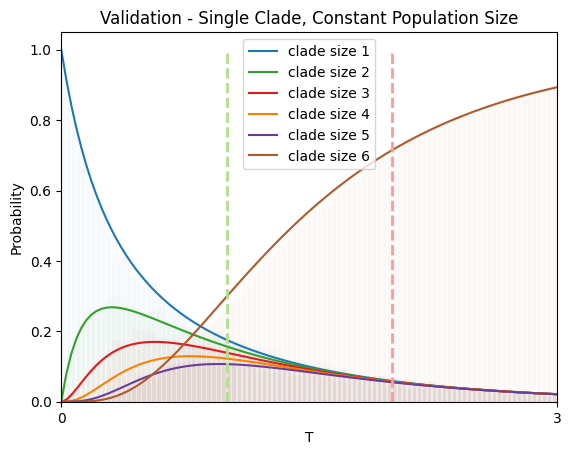

In [ ]:
c#Plotting using python:
#check the closed form solution for finding a clade is correct (Single clade size done)
palette = sns.color_palette("Paired")

tt=sim(6,500,3,100)
c=convert_bar(tt)
gap = 1
ax = plt.gca()
for i, row in enumerate(c):
  t_list = np.linspace(0,3,100)
  plt.bar(t_list, list(map(lambda x: x/500, row)),color=palette[i*2+1],
    width = 0.05,alpha=0.02)
my_xticks = ax.get_xticks()
plt.xlim(0,3)
plt.xticks([my_xticks[1], my_xticks[-2]], visible=True, rotation="horizontal")


n=6
xlist=np.linspace(0,3,100)
ylist=[joint_pro(n,[1],t) for t in xlist]
line1,=plt.plot(xlist,ylist,color=palette[1],label='clade size 1')
ylist=[joint_pro(n,[2],t) for t in xlist]
line2,=plt.plot(xlist,ylist,color=palette[3],label='clade size 2')
ylist=[joint_pro(n,[3],t) for t in xlist]
line3,=plt.plot(xlist,ylist,color=palette[5],label='clade size 3')
ylist=[joint_pro(n,[4],t) for t in xlist]
line4,=plt.plot(xlist,ylist,color=palette[7],label='clade size 4')
ylist=[joint_pro(n,[5],t) for t in xlist]
line5,=plt.plot(xlist,ylist,color=palette[9],label='clade size 5')
ylist=[joint_pro(n,[6],t) for t in xlist]
line6,=plt.plot(xlist,ylist,color=palette[11],label='clade size 6')

plt.vlines(x=1, ymin=0, ymax=1, color=palette[2], ls='--', lw=2)
plt.vlines(x=2, ymin=0, ymax=1, color=palette[4], ls='--', lw=2)

plt.xlabel("T")
plt.ylabel("Probability")
plt.title("Validation - Single Clade, Constant Population Size")
plt.legend(handles=[line1,line2,line3,line4,line5,line6])
#plt.show()
plt.savefig('validation_single_clade.png')

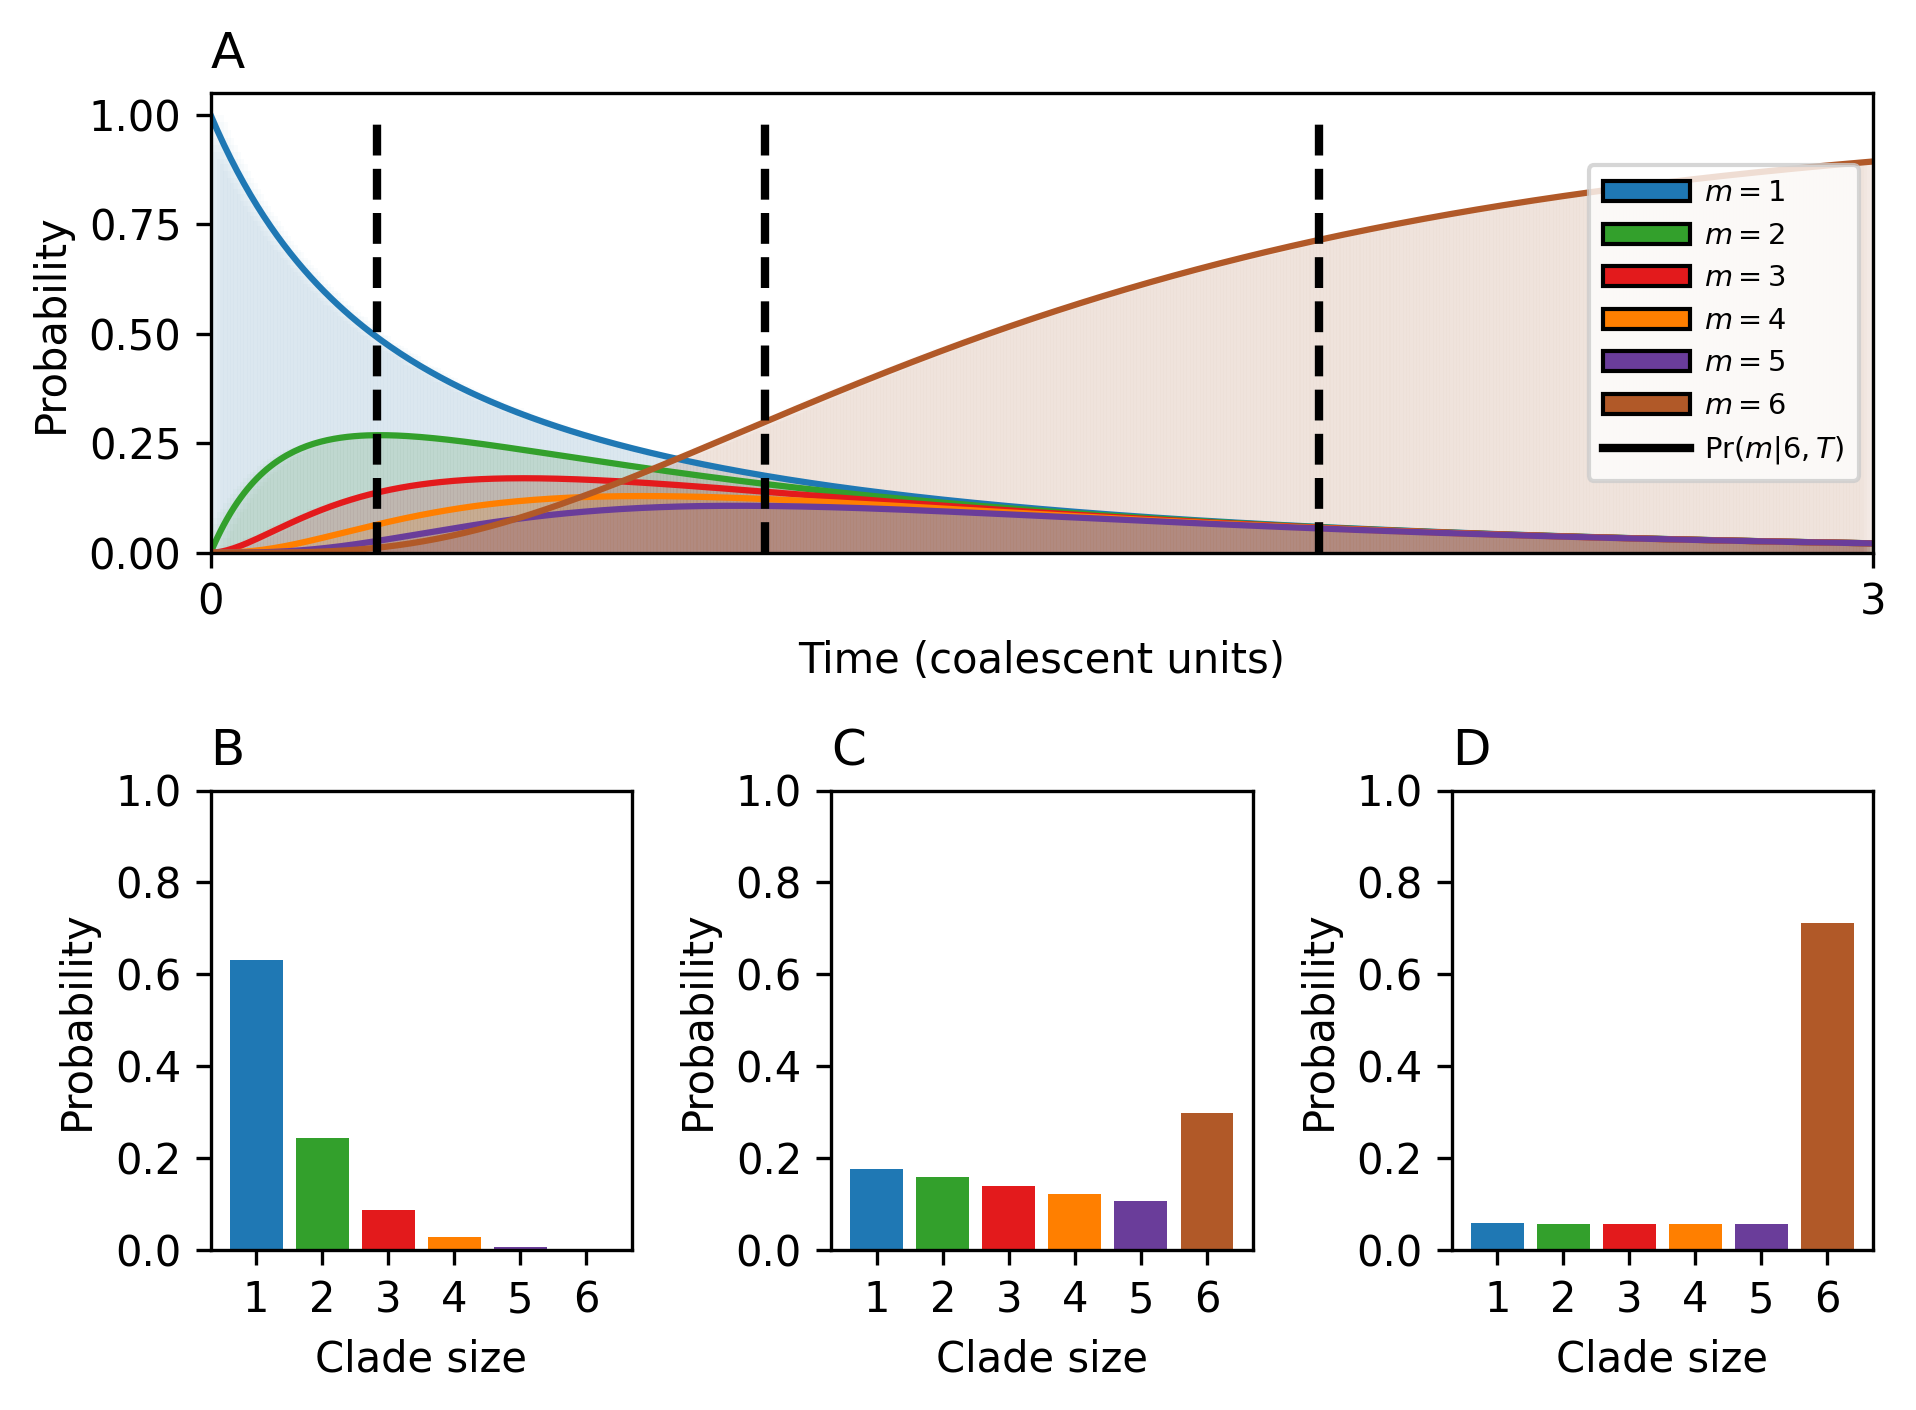

In [ ]:
x = np.arange(0, 7, 0.01)

plt.subplot(2, 1, 1)
palette = sns.color_palette("Paired")

tt=sim(6,50000,3,500)
c=convert_bar(tt)
gap = 1
ax = plt.gca()
for i, row in enumerate(c):
  t_list = np.linspace(0,3,500)
  plt.bar(t_list, list(map(lambda x: x/50000, row)),color=palette[i*2+1],
    width = 0.05,alpha=0.02)
my_xticks = ax.get_xticks()
plt.xlim(0,3)
plt.xticks([my_xticks[1], my_xticks[-2]], visible=True, rotation="horizontal")


n=6
xlist=np.linspace(0,3,500)
ylist=[joint_pro(n,[1],t) for t in xlist]
line1,=plt.plot(xlist,ylist,color=palette[1],label='clade size 1')
ylist=[joint_pro(n,[2],t) for t in xlist]
line2,=plt.plot(xlist,ylist,color=palette[3],label='clade size 2')
ylist=[joint_pro(n,[3],t) for t in xlist]
line3,=plt.plot(xlist,ylist,color=palette[5],label='clade size 3')
ylist=[joint_pro(n,[4],t) for t in xlist]
line4,=plt.plot(xlist,ylist,color=palette[7],label='clade size 4')
ylist=[joint_pro(n,[5],t) for t in xlist]
line5,=plt.plot(xlist,ylist,color=palette[9],label='clade size 5')
ylist=[joint_pro(n,[6],t) for t in xlist]
line6,=plt.plot(xlist,ylist,color=palette[11],label='clade size 6')

plt.vlines(x=0.3, ymin=0, ymax=1, color='black', ls='--', lw=2)
plt.vlines(x=1, ymin=0, ymax=1, color='black', ls='--', lw=2)
plt.vlines(x=2, ymin=0, ymax=1, color='black', ls='--', lw=2)

color_legend_elements = [
    Patch(facecolor=palette[1], edgecolor='black', label='$m=1$'),
    Patch(facecolor=palette[3], edgecolor='black', label='$m=2$'),
    Patch(facecolor=palette[5], edgecolor='black', label='$m=3$'),
    Patch(facecolor=palette[7], edgecolor='black', label='$m=4$'),
    Patch(facecolor=palette[9], edgecolor='black', label='$m=5$'),
    Patch(facecolor=palette[11], edgecolor='black', label='$m=6$'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label=r'Pr$(m|6,T)$'),
]

plt.legend(handles=color_legend_elements, loc='center right',title_fontsize='small', fontsize='x-small', borderpad=0.5,
                         handletextpad=0.5, handlelength=3)




plt.xlabel("Time (coalescent units)")
plt.ylabel("Probability")
plt.title("A",loc='left')
#plt.legend(handles=[line1,line2,line3,line4,line5,line6],loc = 'upper right')
#plt.show()
#plt.savefig('validation_single_clade.png')

plt.subplot(2, 3, 4)
tt1 = t_list.tolist()
#val=tt1.index(1.00400802)
plt.bar(np.arange(len(tt[30])) , list(map(lambda x: x/50000,tt[30]))
,color=(palette[1],palette[3],palette[5],palette[7],palette[9],palette[11]))
plt.ylim([0, 1])
plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6])
plt.xlabel("Clade size")
plt.ylabel("Probability")
plt.title("B",loc='left')


plt.subplot(2, 3, 5)
tt1 = t_list.tolist()
#val=tt1.index(1.00400802)
plt.bar(np.arange(len(tt[167])) , list(map(lambda x: x/50000,tt[167]))
,color=(palette[1],palette[3],palette[5],palette[7],palette[9],palette[11]))
plt.ylim([0, 1])
plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6])

plt.xlabel("Clade size")
plt.ylabel("Probability")
plt.title("C",loc='left')


plt.subplot(2, 3, 6)
plt.bar(np.arange(len(tt[333])) , list(map(lambda x: x/50000,tt[333]))
,color=(palette[1],palette[3],palette[5],palette[7],palette[9],palette[11]))
plt.ylim([0, 1])
plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6])
plt.xlabel("Clade size")
plt.ylabel("Probability")
plt.title("D",loc='left')

plt.tight_layout()

plt.savefig('validation_single_clade.png')


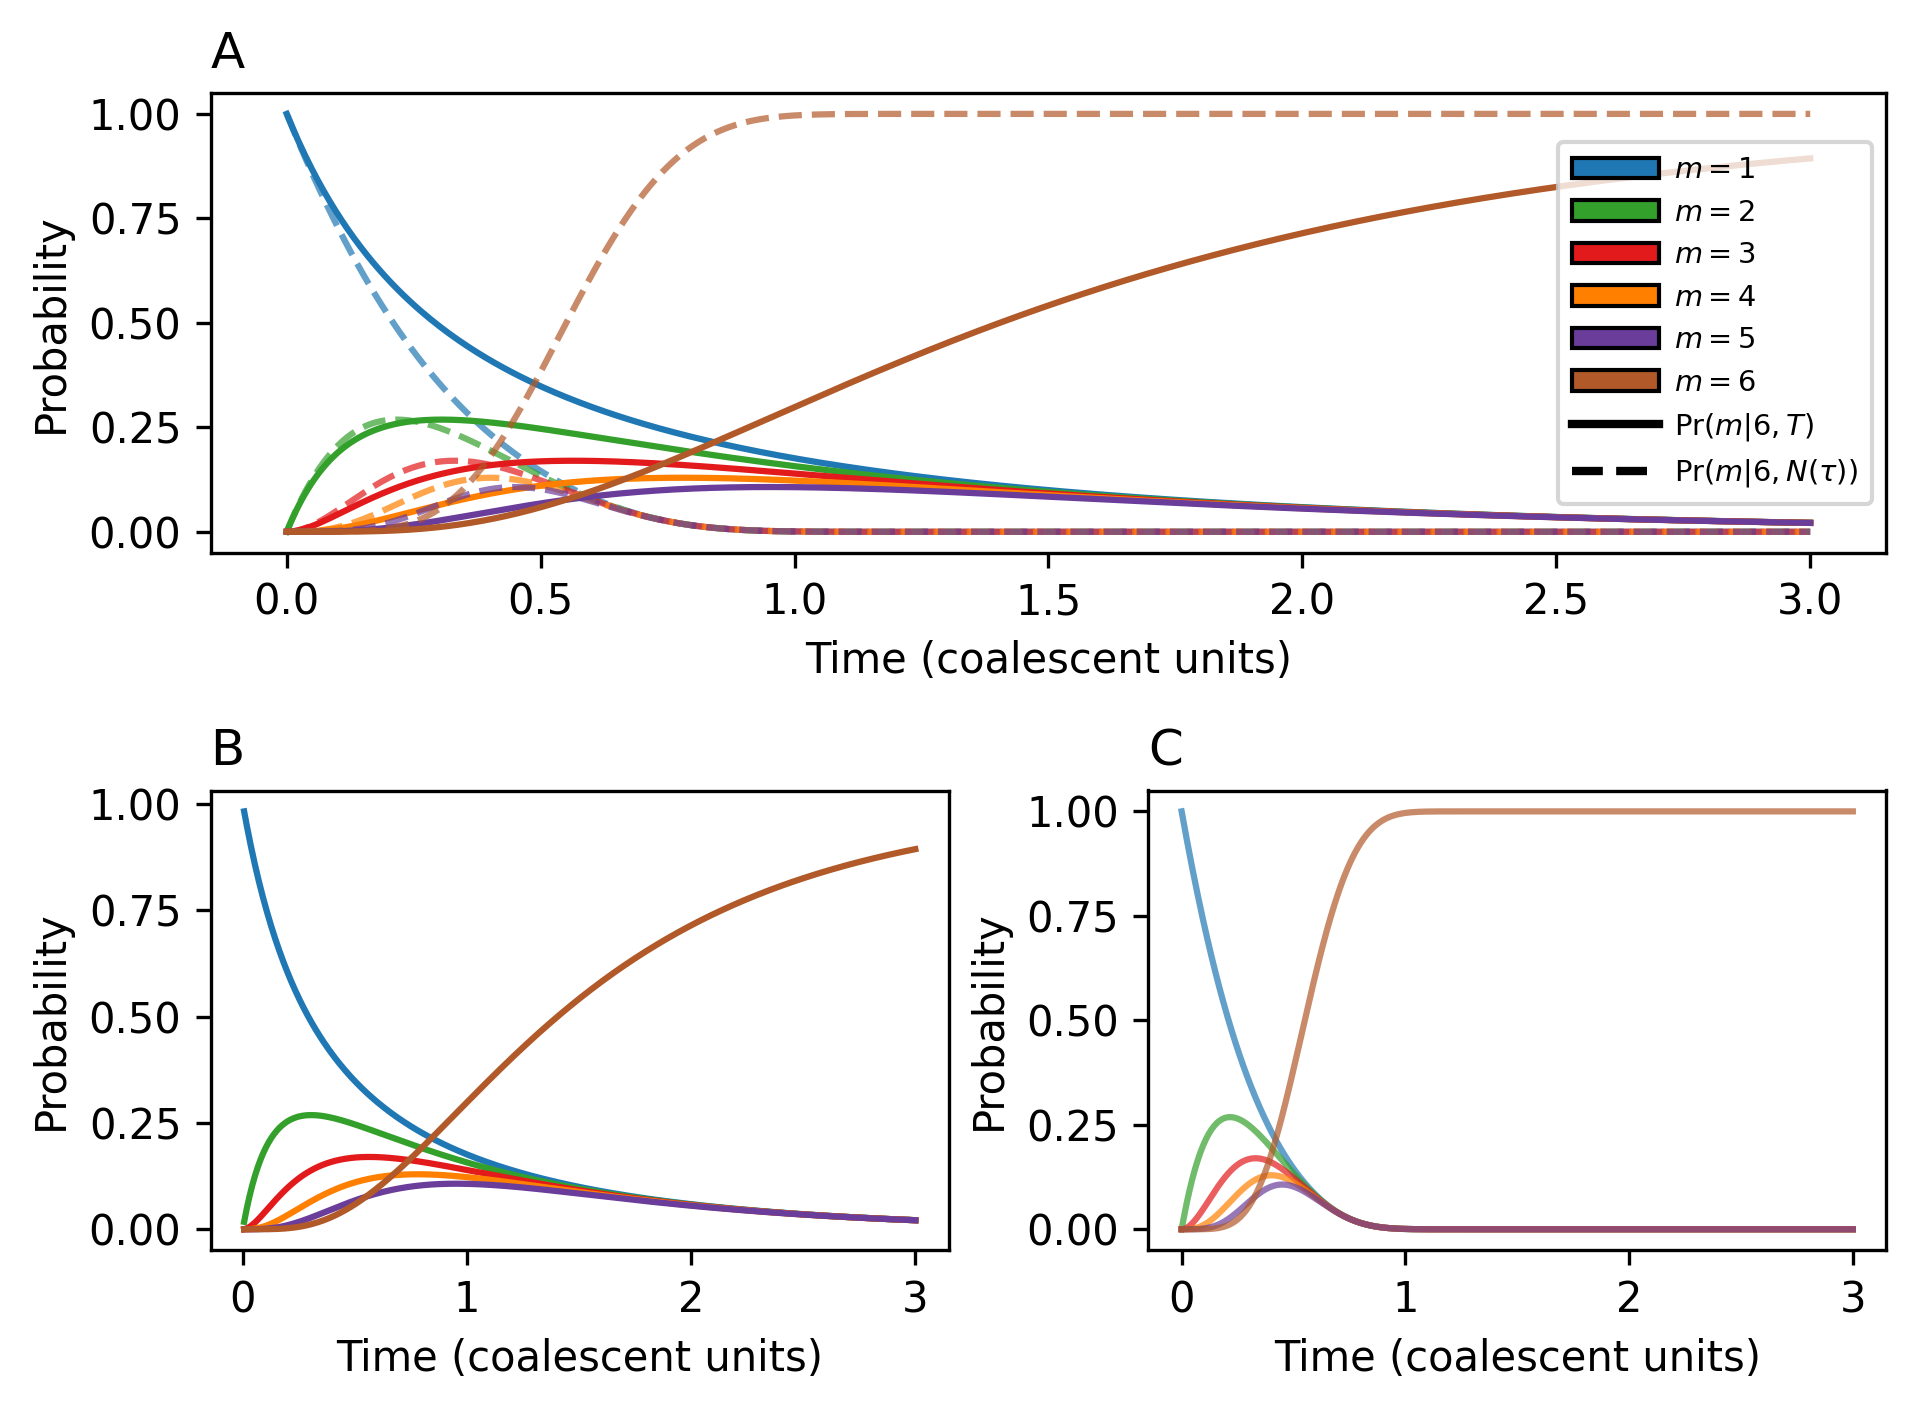

In [ ]:
#arithmetic

#Plotting using python:
#check the closed form solution for finding a clade is correct (exp clade)

plt.subplot(2, 1, 1)

palette = sns.color_palette("Paired")
xlist=np.linspace(0,3,500)

n=6
r=3
ylist=[joint_pro(n,[1],t) for t in xlist]
line1,=plt.plot(xlist,ylist,color=palette[1],label='clade size 1')
ylist=[joint_pro_varying_pop(n,[1],r,t) for t in xlist]
line2,=plt.plot(xlist,ylist,color=palette[1],linestyle='--',alpha=0.7)
ylist=[joint_pro(n,[2],t) for t in xlist]
line3,=plt.plot(xlist,ylist,color=palette[3],label='clade size 2')
ylist=[joint_pro_varying_pop(n,[2],r,t) for t in xlist]
line4,=plt.plot(xlist,ylist,color=palette[3],linestyle='--',alpha=0.7)
ylist=[joint_pro(n,[3],t) for t in xlist]
line5,=plt.plot(xlist,ylist,color=palette[5],label='clade size 3')
ylist=[joint_pro_varying_pop(n,[3],r,t) for t in xlist]
line6,=plt.plot(xlist,ylist,color=palette[5],linestyle='--',alpha=0.7)
ylist=[joint_pro(n,[4],t) for t in xlist]
line7,=plt.plot(xlist,ylist,color=palette[7],label='clade size 4')
ylist=[joint_pro_varying_pop(n,[4],r,t) for t in xlist]
line8,=plt.plot(xlist,ylist,color=palette[7],linestyle='--',alpha=0.7)
ylist=[joint_pro(n,[5],t) for t in xlist]
line9,=plt.plot(xlist,ylist,color=palette[9],label='clade size 5')
ylist=[joint_pro_varying_pop(n,[5],r,t) for t in xlist]
line10,=plt.plot(xlist,ylist,color=palette[9],linestyle='--',alpha=0.7)
ylist=[joint_pro(n,[6],t) for t in xlist]
line11,=plt.plot(xlist,ylist,color=palette[11],label='clade size 6')
ylist=[joint_pro_varying_pop(n,[6],r,t) for t in xlist]
line12,=plt.plot(xlist,ylist,color=palette[11],linestyle='--',alpha=0.7)


color_legend_elements = [
    Patch(facecolor=palette[1], edgecolor='black', label='$m=1$'),
    Patch(facecolor=palette[3], edgecolor='black', label='$m=2$'),
    Patch(facecolor=palette[5], edgecolor='black', label='$m=3$'),
    Patch(facecolor=palette[7], edgecolor='black', label='$m=4$'),
    Patch(facecolor=palette[9], edgecolor='black', label='$m=5$'),
    Patch(facecolor=palette[11], edgecolor='black', label='$m=6$'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label=r'Pr$(m|6,T)$'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label=r'Pr$(m|6,N(\tau))$')
]

# Create custom legend handles for line styles
line_legend_elements = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', label='Clade Size'),
    Line2D([0], [0], color='black', lw=1, linestyle=(0, (5, 5)), label='Individual Size')
]

plt.legend(handles=color_legend_elements, loc='center right',title_fontsize='small', fontsize='x-small', borderpad=0.5,
                         handletextpad=0.5, handlelength=3)


plt.xlabel("Time (coalescent units)")
plt.ylabel("Probability")
plt.title("A",loc='left')
#plt.title("Validation - Single Clade, Exponential Growth Population Size (r=3)")
#plt.legend(handles=[line1,line3,line5,line7,line9,line11],loc='upper right')
#plt.show()

#harmonic

#Plotting using python:
#check the closed form solution for finding a clade is correct (exp clade)
plt.subplot(2, 2, 3 )

ylist=[joint_pro_varying_pop_tavare_harmonic(n,[1],r,t) for t in xlist]
line1,=plt.plot(xlist,ylist,color=palette[1],label='clade size 1')
ylist=[joint_pro_varying_pop_tavare_harmonic(n,[2],r,t) for t in xlist]
line3,=plt.plot(xlist,ylist,color=palette[3],label='clade size 2')
ylist=[joint_pro_varying_pop_tavare_harmonic(n,[3],r,t) for t in xlist]
line5,=plt.plot(xlist,ylist,color=palette[5],label='clade size 3')
ylist=[joint_pro_varying_pop_tavare_harmonic(n,[4],r,t) for t in xlist]
line7,=plt.plot(xlist,ylist,color=palette[7],label='clade size 4')
ylist=[joint_pro_varying_pop_tavare_harmonic(n,[5],r,t) for t in xlist]
line9,=plt.plot(xlist,ylist,color=palette[9],label='clade size 5')
ylist=[joint_pro_varying_pop_tavare_harmonic(n,[6],r,t) for t in xlist]
line11,=plt.plot(xlist,ylist,color=palette[11],label='clade size 6')


plt.xlabel("Time (coalescent units)")
plt.ylabel("Probability")
plt.title("B",loc='left')


#constant
plt.subplot(2, 2, 4 )
ylist=[joint_pro_varying_pop(n,[1],r,t) for t in xlist]
line2,=plt.plot(xlist,ylist,color=palette[1],alpha=0.7)
ylist=[joint_pro_varying_pop(n,[2],r,t) for t in xlist]
line4,=plt.plot(xlist,ylist,color=palette[3],alpha=0.7)
ylist=[joint_pro_varying_pop(n,[3],r,t) for t in xlist]
line6,=plt.plot(xlist,ylist,color=palette[5],alpha=0.7)
ylist=[joint_pro_varying_pop(n,[4],r,t) for t in xlist]
line8,=plt.plot(xlist,ylist,color=palette[7],alpha=0.7)
ylist=[joint_pro_varying_pop(n,[5],r,t) for t in xlist]
line10,=plt.plot(xlist,ylist,color=palette[9],alpha=0.7)
ylist=[joint_pro_varying_pop(n,[6],r,t) for t in xlist]
line12,=plt.plot(xlist,ylist,color=palette[11],alpha=0.7)
plt.xlabel("Time (coalescent units)")
plt.ylabel("Probability")
plt.title("C",loc='left')

plt.tight_layout()

plt.savefig('exp.png')



<BarContainer object of 6 artists>

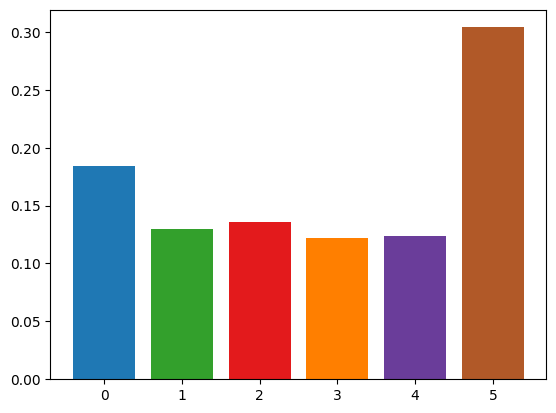

In [ ]:
~plt.bar(np.arange(len(tt[val])) , list(map(lambda x: x/500,tt[val]))
,color=(palette[1],palette[3],palette[5],palette[7],palette[9],palette[11]))

In [ ]:
tt1[333]

2.002004008016032

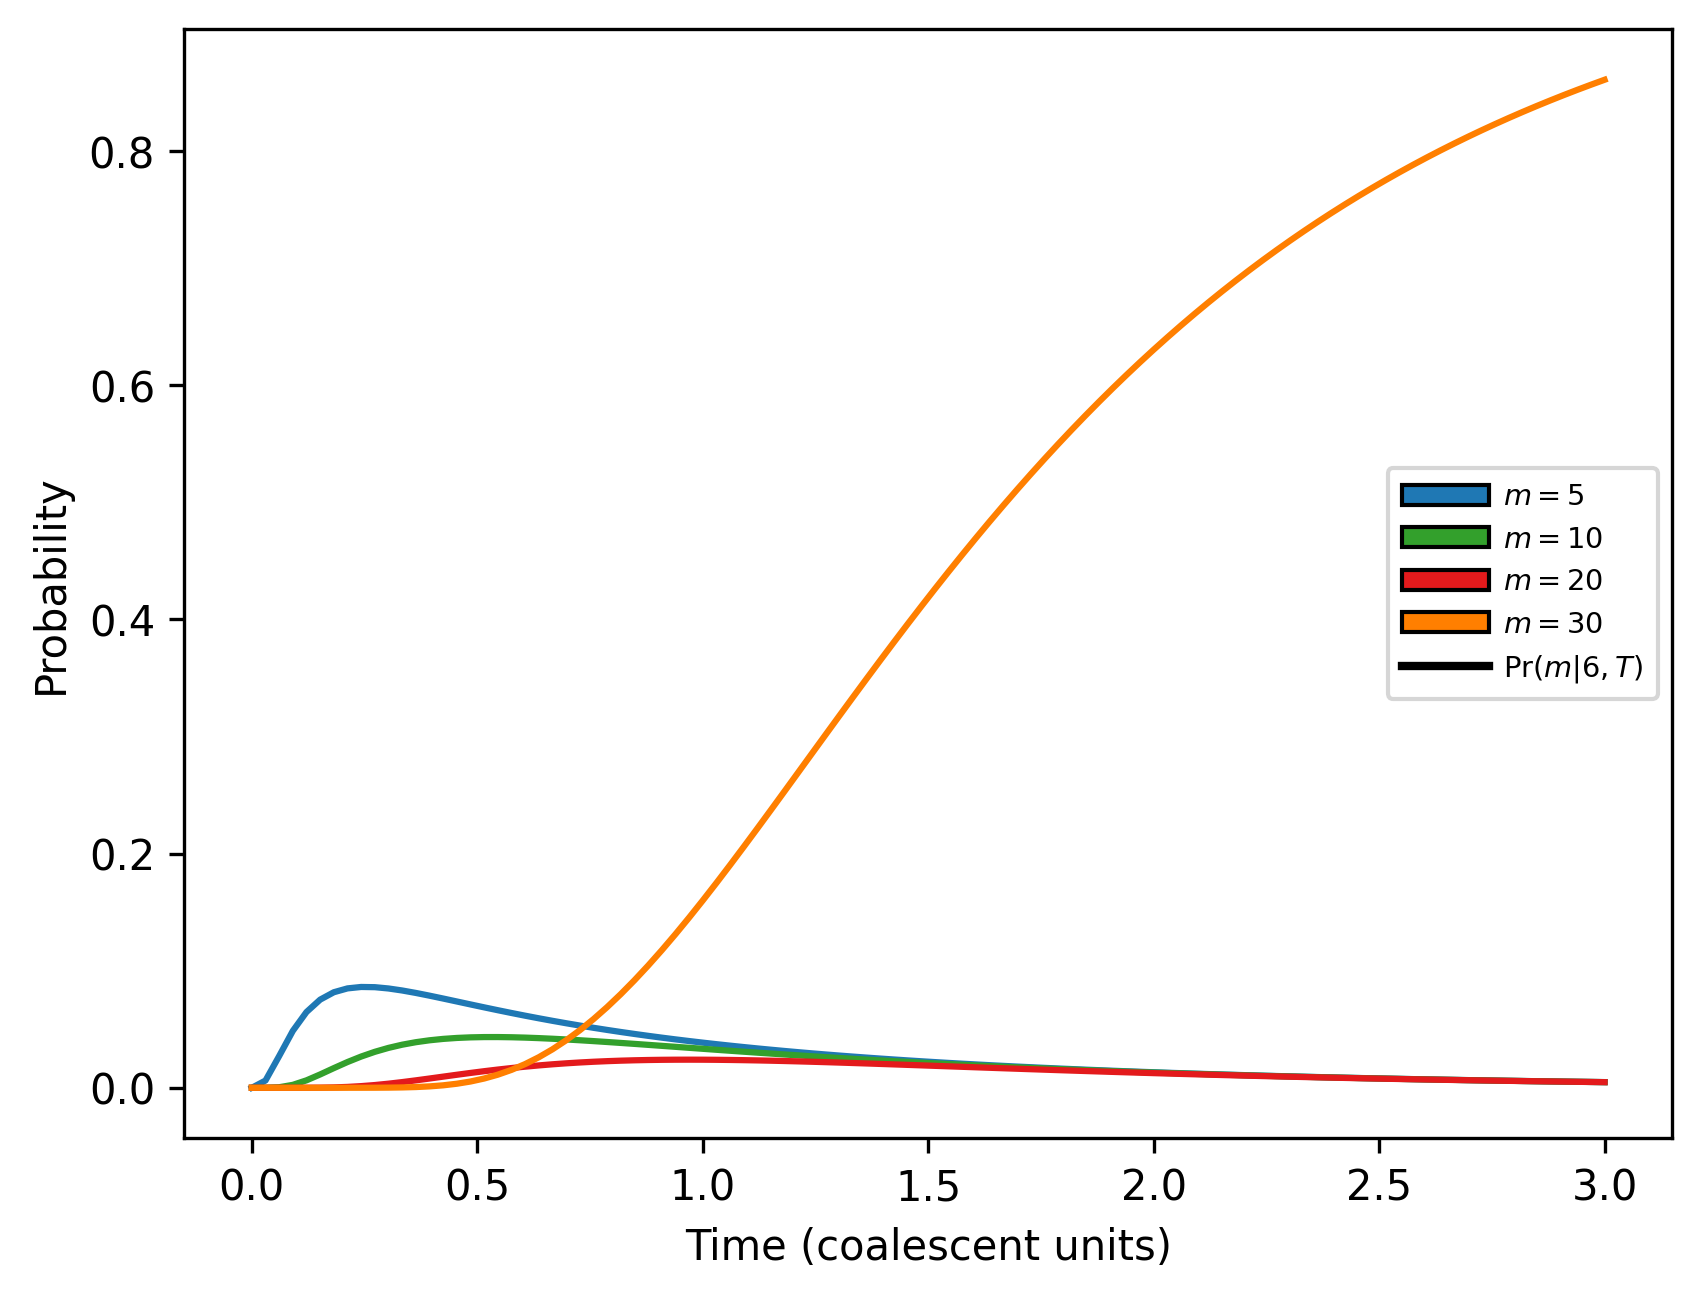

In [ ]:
palette = sns.color_palette("Paired")

n=30
xlist=np.linspace(0,3,100)
#ylist=[joint_pro(n,[1],t) for t in xlist]
#line1,=plt.plot(xlist,ylist,color=palette[1],label='clade size 1')
ylist=[joint_pro(n,[5],t) for t in xlist]
line2,=plt.plot(xlist,ylist,color=palette[1],label='clade size 5')
ylist=[joint_pro(n,[10],t) for t in xlist]
line3,=plt.plot(xlist,ylist,color=palette[3],label='clade size 10')
ylist=[joint_pro(n,[20],t) for t in xlist]
line4,=plt.plot(xlist,ylist,color=palette[5],label='clade size 20')
ylist=[joint_pro(n,[30],t) for t in xlist]
line5,=plt.plot(xlist,ylist,color=palette[7],label='clade size 30')


plt.xlabel("Time (coalescent units)")
plt.ylabel("Probability")


color_legend_elements = [
    Patch(facecolor=palette[1], edgecolor='black', label='$m=5$'),
    Patch(facecolor=palette[3], edgecolor='black', label='$m=10$'),
    Patch(facecolor=palette[5], edgecolor='black', label='$m=20$'),
    Patch(facecolor=palette[7], edgecolor='black', label='$m=30$'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label=r'Pr$(m|6,T)$'),
]

# Create custom legend handles for line styles

plt.legend(handles=color_legend_elements, loc='center right',title_fontsize='small', fontsize='x-small', borderpad=0.5,
                         handletextpad=0.5, handlelength=3)

plt.savefig('single_clade_more_samples.png')
#plt.show()
#plt.savefig('single_clade_more_samples.png')

### Multiple clades, constant population size

In [ ]:
def sim_multiple_clade(m,l,times,maxt,inc):
  # pick l number of clades at the same time, l in partition configuration
  t_list = np.linspace(0,maxt,inc)
  le = len(t_list)
  ini_list = [0]
  out = []
  for i in range(len(t_list)):
    out.append(ini_list[:]) #for evert time step, initialize the number of obs = 0
  for i in range(times):
    sim = sim_single_clade(m)
    for j in range(le):
      val = rand_sample_multi(sim,t_list[j],l)
      if Counter(val) == Counter(l):
        out[j][0] = out[j][0]+1
  return(out)

'\nplt.xlabel("T")\nplt.ylabel("Probability")\nplt.title("Validation - Multiple Clades, Constant Population Size")\nplt.legend(handles=[line1,line2,line3])\n#plt.show()\nplt.savefig(\'validation_mul_clades.png\')\n'

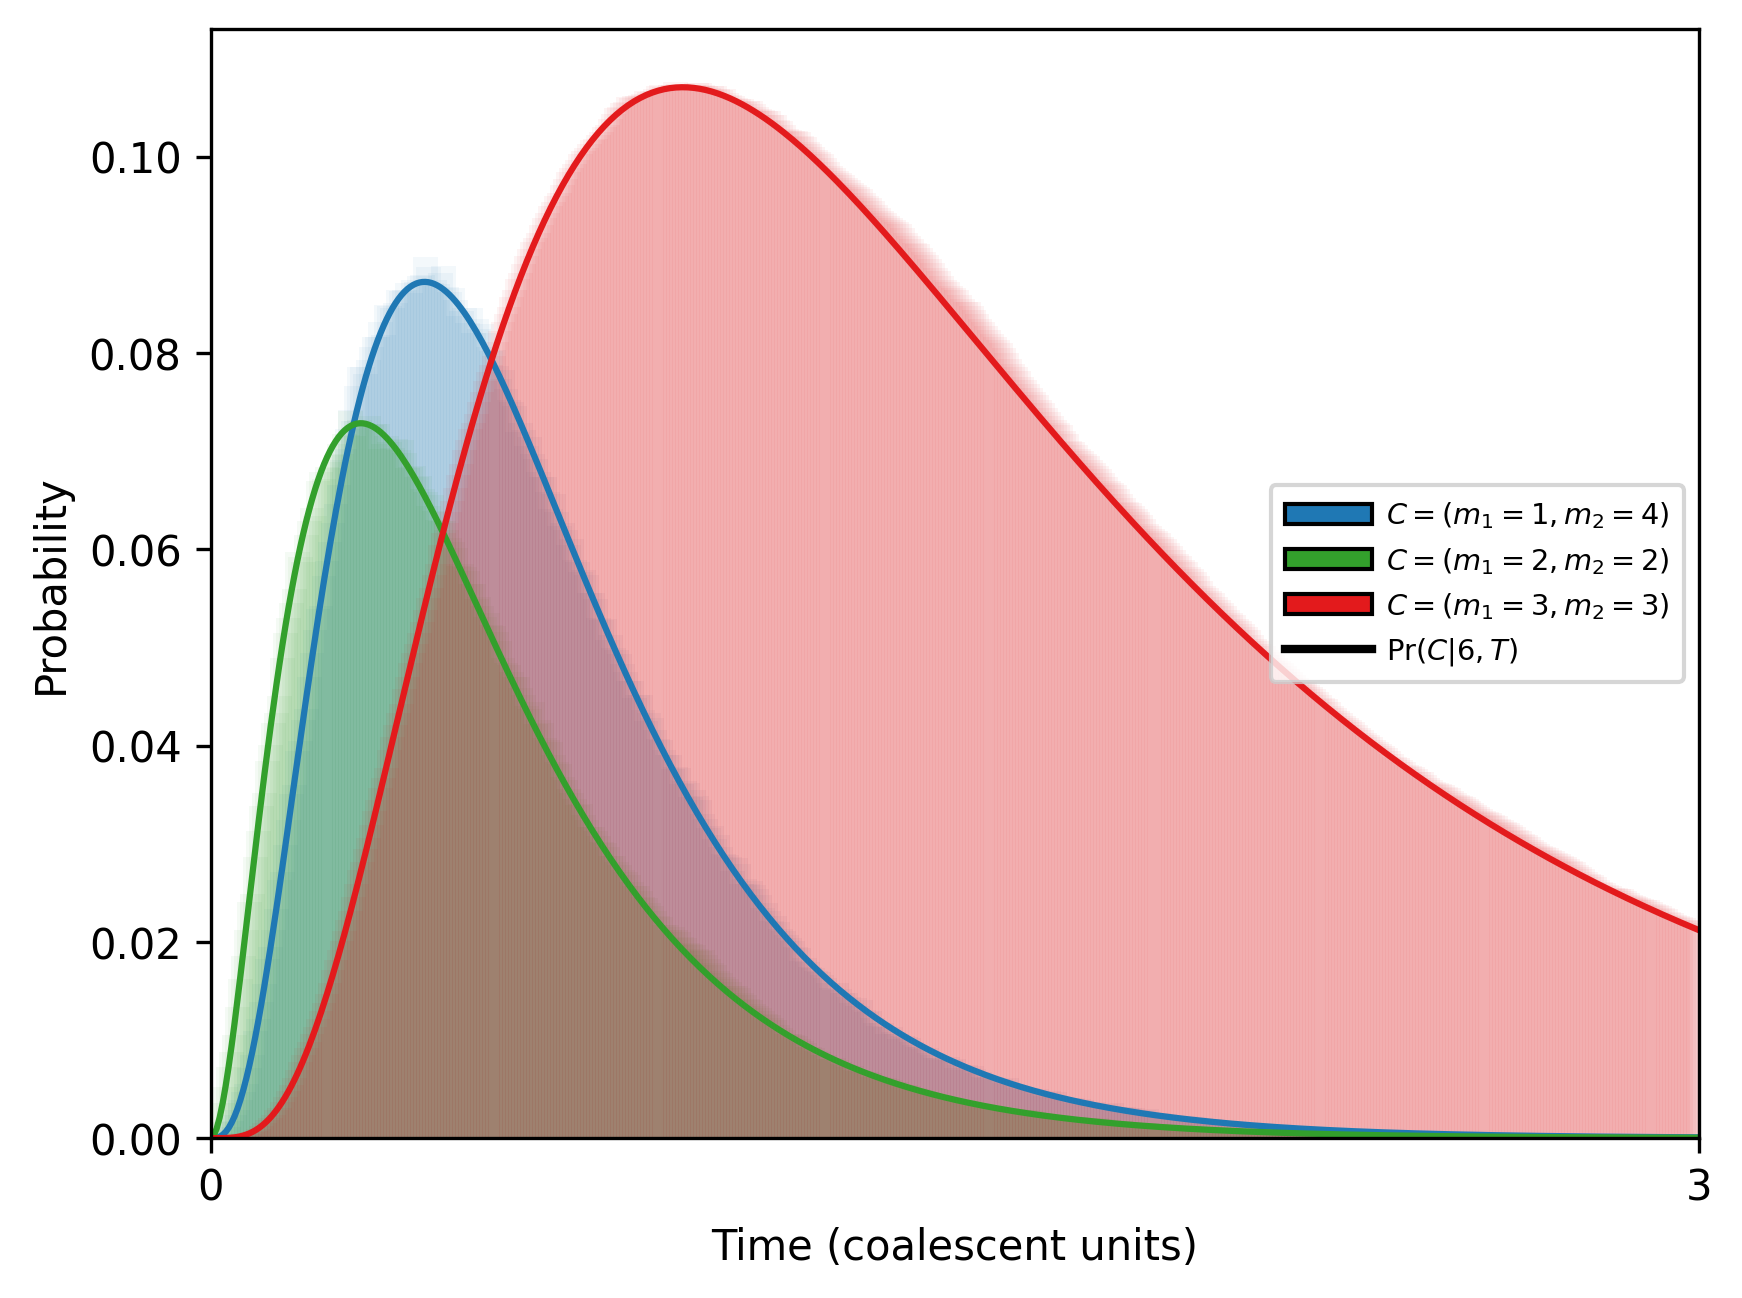

In [ ]:
#Plotting using python:
#check this is correct! (Joint clade size done)
#check the closed form solution for finding a clade is correct
palette = sns.color_palette("Paired")

tt=sim_multiple_clade(6,[1,4],50000,3,500)
merged = list(itertools.chain.from_iterable(tt))
gap = 1
ax = plt.gca()
t_list = np.linspace(0,3,500)
plt.bar(t_list,list(map(lambda x: x/50000,merged)),color=palette[1],width = 0.05, alpha=0.05)
my_xticks = ax.get_xticks()
plt.xlim(0,3)
plt.xticks([my_xticks[1], my_xticks[-2]], visible=True, rotation="horizontal")


tt=sim_multiple_clade(6,[2,2],50000,3,500)
merged = list(itertools.chain.from_iterable(tt))
gap = 1
ax = plt.gca()
t_list = np.linspace(0,3,500)
plt.bar(t_list,list(map(lambda x: x/50000,merged)),color=palette[3],width = 0.05, alpha=0.05)
my_xticks = ax.get_xticks()
plt.xlim(0,3)
plt.xticks([my_xticks[1], my_xticks[-2]], visible=True, rotation="horizontal")


tt=sim_multiple_clade(6,[3,3],50000,3,500)
merged = list(itertools.chain.from_iterable(tt))
gap = 1
ax = plt.gca()
t_list = np.linspace(0,3,500)
plt.bar(t_list,list(map(lambda x: x/50000,merged)),color=palette[5],width = 0.05, alpha=0.05)
my_xticks = ax.get_xticks()
plt.xlim(0,3)
plt.xticks([my_xticks[1], my_xticks[-2]], visible=True, rotation="horizontal")


n=6
xlist=np.linspace(0,3,500)

ylist=[joint_pro(n,[1,4],t) for t in xlist]
line1,=plt.plot(xlist,ylist,color=palette[1],label='clade size 1,1')


ylist=[joint_pro(n,[2,2],t) for t in xlist]
line2,=plt.plot(xlist,ylist,color=palette[3],label='clade size 2,2')


ylist=[joint_pro(n,[3,3],t) for t in xlist]
line3,=plt.plot(xlist,ylist,color=palette[5],label='clade size 1,1,2')


plt.xlabel("Time (coalescent units)")
plt.ylabel("Probability")


color_legend_elements = [
    Patch(facecolor=palette[1], edgecolor='black', label='$C=(m_1=1,m_2=4)$'),
    Patch(facecolor=palette[3], edgecolor='black', label='$C=(m_1=2,m_2=2)$'),
    Patch(facecolor=palette[5], edgecolor='black', label='$C=(m_1=3,m_2=3)$'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label=r'Pr$(C|6,T)$'),
]

# Create custom legend handles for line styles
line_legend_elements = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', label='Clade Size'),
    Line2D([0], [0], color='black', lw=1, linestyle=(0, (5, 5)), label='Individual Size')
]

plt.legend(handles=color_legend_elements, loc='center right',title_fontsize='small', fontsize='x-small', borderpad=0.5,
                         handletextpad=0.5, handlelength=3)

plt.savefig('validation_mul_clades.png')


'''
plt.xlabel("T")
plt.ylabel("Probability")
plt.title("Validation - Multiple Clades, Constant Population Size")
plt.legend(handles=[line1,line2,line3])
#plt.show()
plt.savefig('validation_mul_clades.png')
'''

In [ ]:
def sim_multiple_clade(m,times,maxt,inc):
  # pick l number of clades at the same time
  t_list = np.linspace(0,maxt,inc)
  l = len(t_list)
  ini_list = [0]*m #get the number of list
  out = []
  for i in range(l):
    out.append(ini_list[:])

  for i in range(times):
    sim = sim_single_clade(m)
    for j in range(l):
      val = rand_sample(sim,t_list[j])
      out[j][val-1] = out[j][val-1]+1
  return(out)

### Single Individual, constant population size

'\nplt.xlabel("T")\nplt.ylabel("Probability")\nplt.title("Validation - Single Individual, Constant Population Size")\nplt.legend(handles=[line1,line2,line3])\n#plt.show()\nplt.savefig(\'validation_single_ind.png\')\n'

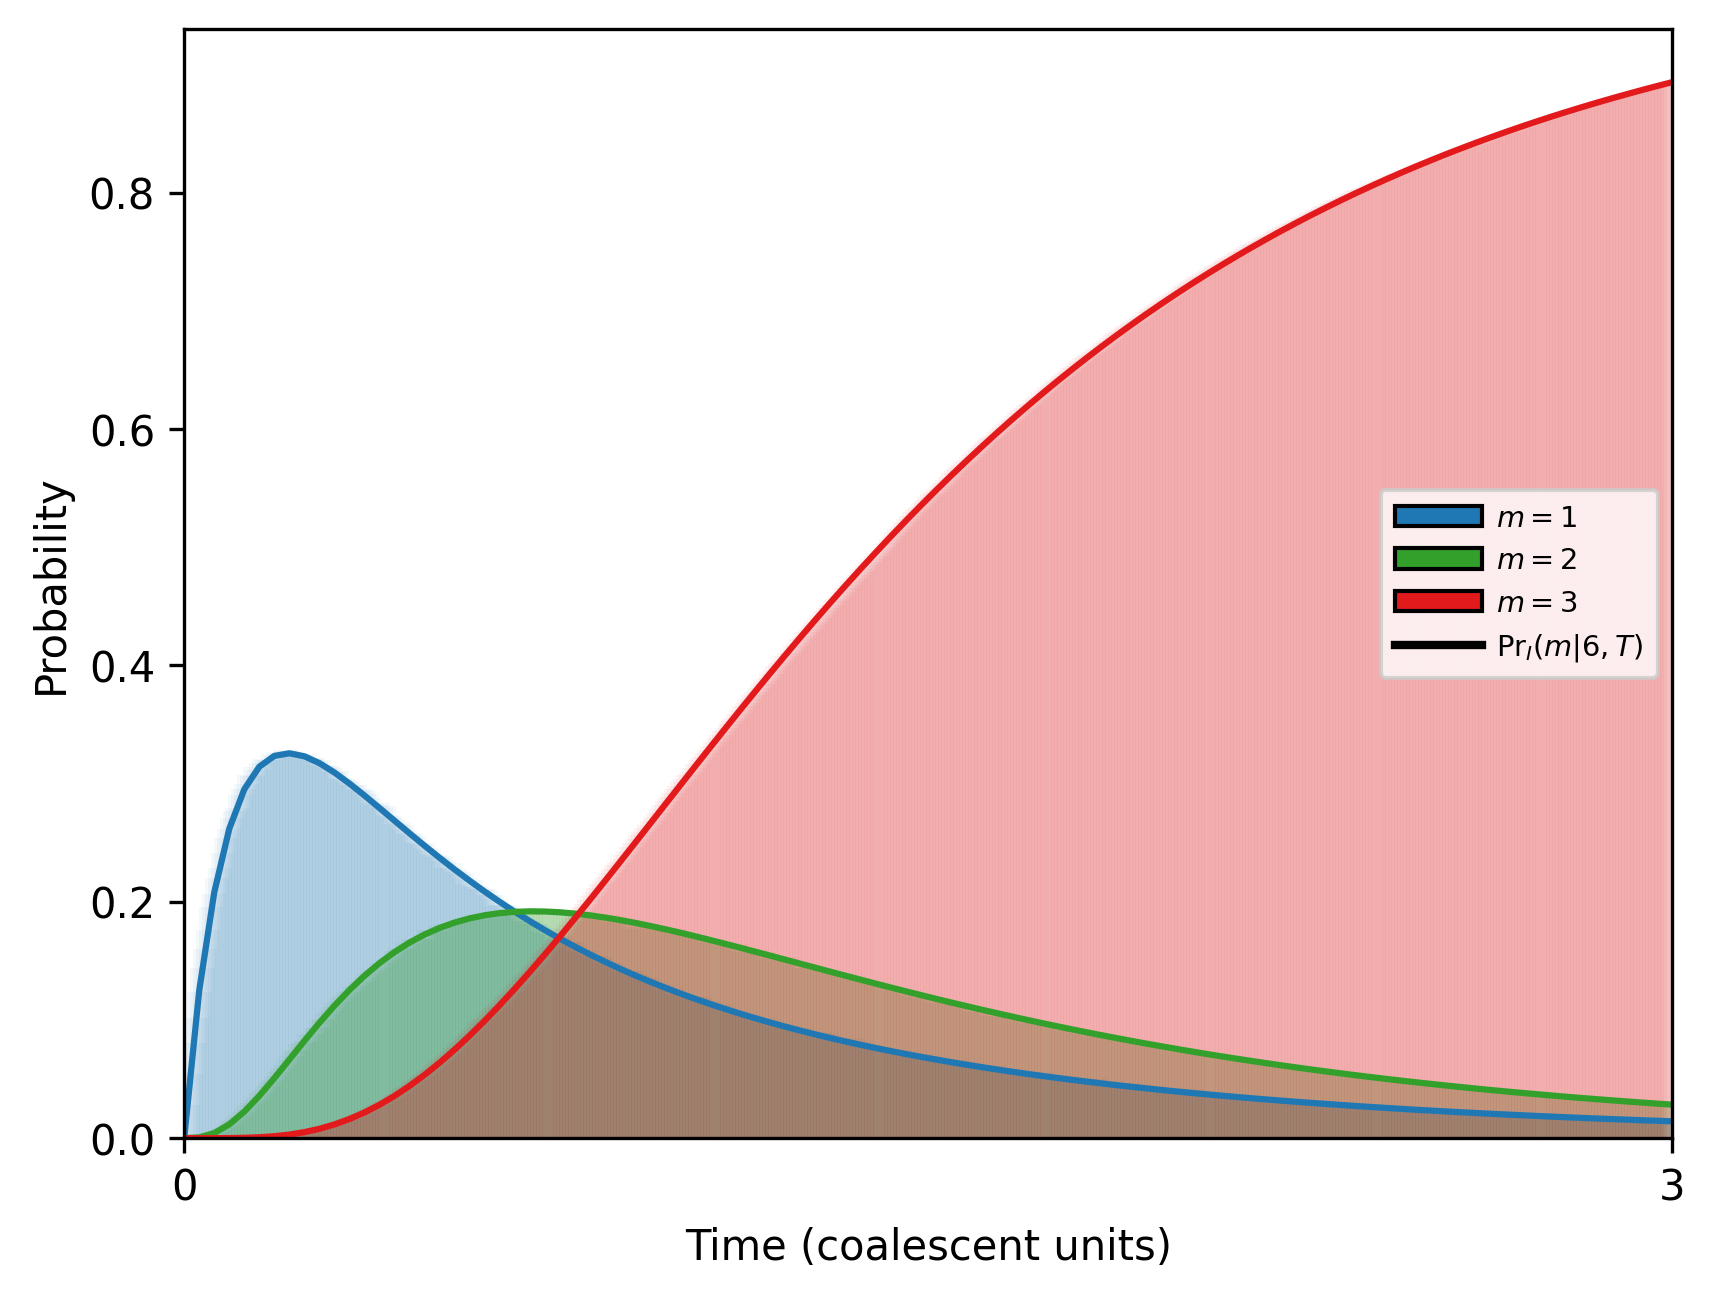

In [ ]:
#Plotting using python:
#check this is correct! (single individual done)
#check the closed form solution for finding a clade is correct
palette = sns.color_palette("Paired")

tt=sim_i_single(6,2,50000,3,500)
merged = list(itertools.chain.from_iterable(tt))

gap = 1
ax = plt.gca()
t_list = np.linspace(0,3,500)
plt.bar(t_list,list(map(lambda x: x/50000,merged)),color=palette[1],width = 0.05, alpha=0.05)
my_xticks = ax.get_xticks()
plt.xlim(0,3)
plt.xticks([my_xticks[1], my_xticks[-2]], visible=True, rotation="horizontal")


tt=sim_i_single(6,4,50000,3,500)
merged = list(itertools.chain.from_iterable(tt))
gap = 1
ax = plt.gca()
t_list = np.linspace(0,3,500)
plt.bar(t_list,list(map(lambda x: x/50000,merged)),color=palette[3],width = 0.05, alpha=0.05)
my_xticks = ax.get_xticks()
plt.xlim(0,3)
plt.xticks([my_xticks[1], my_xticks[-2]], visible=True, rotation="horizontal")


tt=sim_i_single(6,6,50000,3,500)
merged = list(itertools.chain.from_iterable(tt))

gap = 1
ax = plt.gca()
t_list = np.linspace(0,3,500)
plt.bar(t_list,list(map(lambda x: x/50000,merged)),color=palette[5],width = 0.05, alpha=0.05)
my_xticks = ax.get_xticks()
plt.xlim(0,3)
plt.xticks([my_xticks[1], my_xticks[-2]], visible=True, rotation="horizontal")


n=6
xlist=np.linspace(0,3,100)
ylist=[pro_ind(n,2,t) for t in xlist]
line1,=plt.plot(xlist,ylist,color=palette[1],label='clade size 2')

ylist=[pro_ind(n,4,t) for t in xlist]
line2,=plt.plot(xlist,ylist,color=palette[3],label='clade size 4')

ylist=[pro_ind(n,6,t) for t in xlist]
line3,=plt.plot(xlist,ylist,color=palette[5],label='clade size 6')



plt.xlabel("Time (coalescent units)")
plt.ylabel("Probability")


color_legend_elements = [
    Patch(facecolor=palette[1], edgecolor='black', label='$m=1$'),
    Patch(facecolor=palette[3], edgecolor='black', label='$m=2$'),
    Patch(facecolor=palette[5], edgecolor='black', label='$m=3$'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label=r'Pr$_I(m|6,T)$'),
]

# Create custom legend handles for line styles
line_legend_elements = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', label='Clade Size'),
    Line2D([0], [0], color='black', lw=1, linestyle=(0, (5, 5)), label='Individual Size')
]

plt.legend(handles=color_legend_elements, loc='center right',title_fontsize='small', fontsize='x-small', borderpad=0.5,
                         handletextpad=0.5, handlelength=3)

plt.savefig('validation_single_ind.png')

'''
plt.xlabel("T")
plt.ylabel("Probability")
plt.title("Validation - Single Individual, Constant Population Size")
plt.legend(handles=[line1,line2,line3])
#plt.show()
plt.savefig('validation_single_ind.png')
'''

### Multiple individuals, constant population size

'\nplt.xlabel("T")\nplt.ylabel("Probability")\nplt.title("Validation - Multiple Individual, Constant Population Size")\nplt.legend(handles=[line1,line2,line3])\n#plt.show()\nplt.savefig(\'validation_mul_ind.png\')\n'

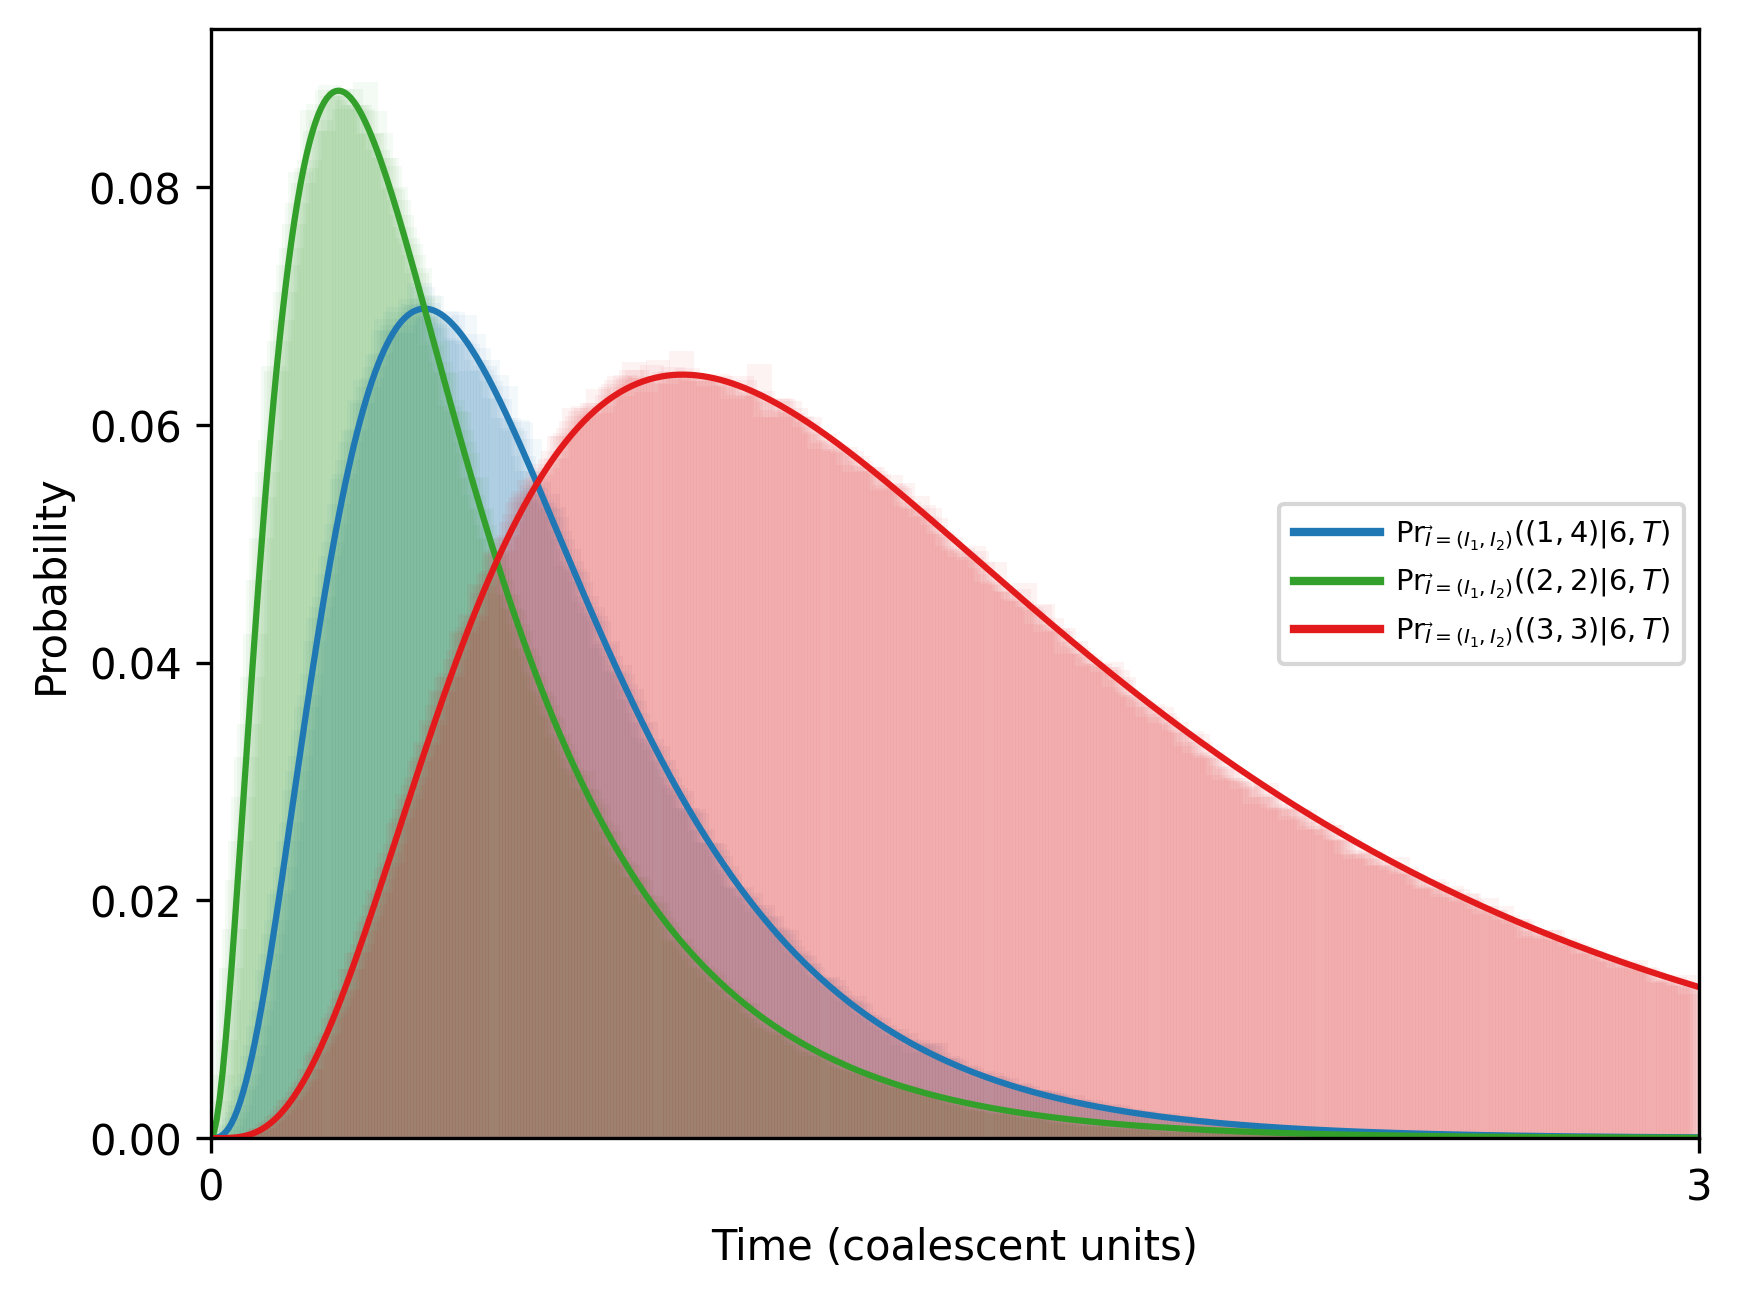

In [ ]:
#Plotting using python:
#check this is correct! (multiple individuals done)
#check the closed form solution for finding a clade is correct
palette = sns.color_palette("Paired")

tt=sim_i_multi(6,2,[1,4],50000,3,500)
merged = list(itertools.chain.from_iterable(tt))
gap = 1
ax = plt.gca()
t_list = np.linspace(0,3,500)
plt.bar(t_list,list(map(lambda x: x/50000,merged)),color=palette[1],width = 0.05, alpha=0.05)
my_xticks = ax.get_xticks()
plt.xlim(0,3)
plt.xticks([my_xticks[1], my_xticks[-2]], visible=True, rotation="horizontal")


tt2=sim_i_multi(6,2,[2,2],50000,3,500)
merged = list(itertools.chain.from_iterable(tt2))
gap = 1
ax = plt.gca()
t_list = np.linspace(0,3,500)
plt.bar(t_list,list(map(lambda x: x/50000,merged)),color=palette[3],width = 0.05, alpha=0.05)
my_xticks = ax.get_xticks()
plt.xlim(0,3)
plt.xticks([my_xticks[1], my_xticks[-2]], visible=True, rotation="horizontal")


tt3=sim_i_multi(6,2,[3,3],50000,3,500)
merged = list(itertools.chain.from_iterable(tt3))
gap = 1
ax = plt.gca()
t_list = np.linspace(0,3,500)
plt.bar(t_list,list(map(lambda x: x/50000,merged)),color=palette[5],width = 0.05, alpha=0.05)
my_xticks = ax.get_xticks()
plt.xlim(0,3)
plt.xticks([my_xticks[1], my_xticks[-2]], visible=True, rotation="horizontal")


n=6
xlist=np.linspace(0,3,500)
ylist=[joint_pro_ind(n,2,[1,4],t) for t in xlist]
line1,=plt.plot(xlist,ylist,color=palette[1],label='4 individuals in clade (2,2)')

ylist=[joint_pro_ind(n,2,[2,2],t) for t in xlist]
line2,=plt.plot(xlist,ylist,color=palette[3],label='6 individuals in clade (4,2)')

ylist=[joint_pro_ind(n,2,[3,3],t) for t in xlist]
line3,=plt.plot(xlist,ylist,color=palette[5],label='3 individuals in clade (1,2)')


plt.xlabel("Time (coalescent units)")
plt.ylabel("Probability")


color_legend_elements = [
    Line2D([0], [0], color=palette[1], lw=2, linestyle='-', label=r'Pr$_{\vec I = (I_1,I_2)}((1,4)|6,T)$'),
    Line2D([0], [0], color=palette[3], lw=2, linestyle='-', label=r'Pr$_{\vec I = (I_1,I_2)}((2,2)|6,T)$'),
    Line2D([0], [0], color=palette[5], lw=2, linestyle='-', label=r'Pr$_{\vec I = (I_1,I_2)}((3,3)|6,T)$'),
]

plt.legend(handles=color_legend_elements, loc='center right',title_fontsize='small', fontsize='x-small', borderpad=0.5,
                         handletextpad=0.5, handlelength=3)

plt.savefig('validation_mul_ind.png')


'''
plt.xlabel("T")
plt.ylabel("Probability")
plt.title("Validation - Multiple Individual, Constant Population Size")
plt.legend(handles=[line1,line2,line3])
#plt.show()
plt.savefig('validation_mul_ind.png')
'''

### Single clade, exponential growth population size

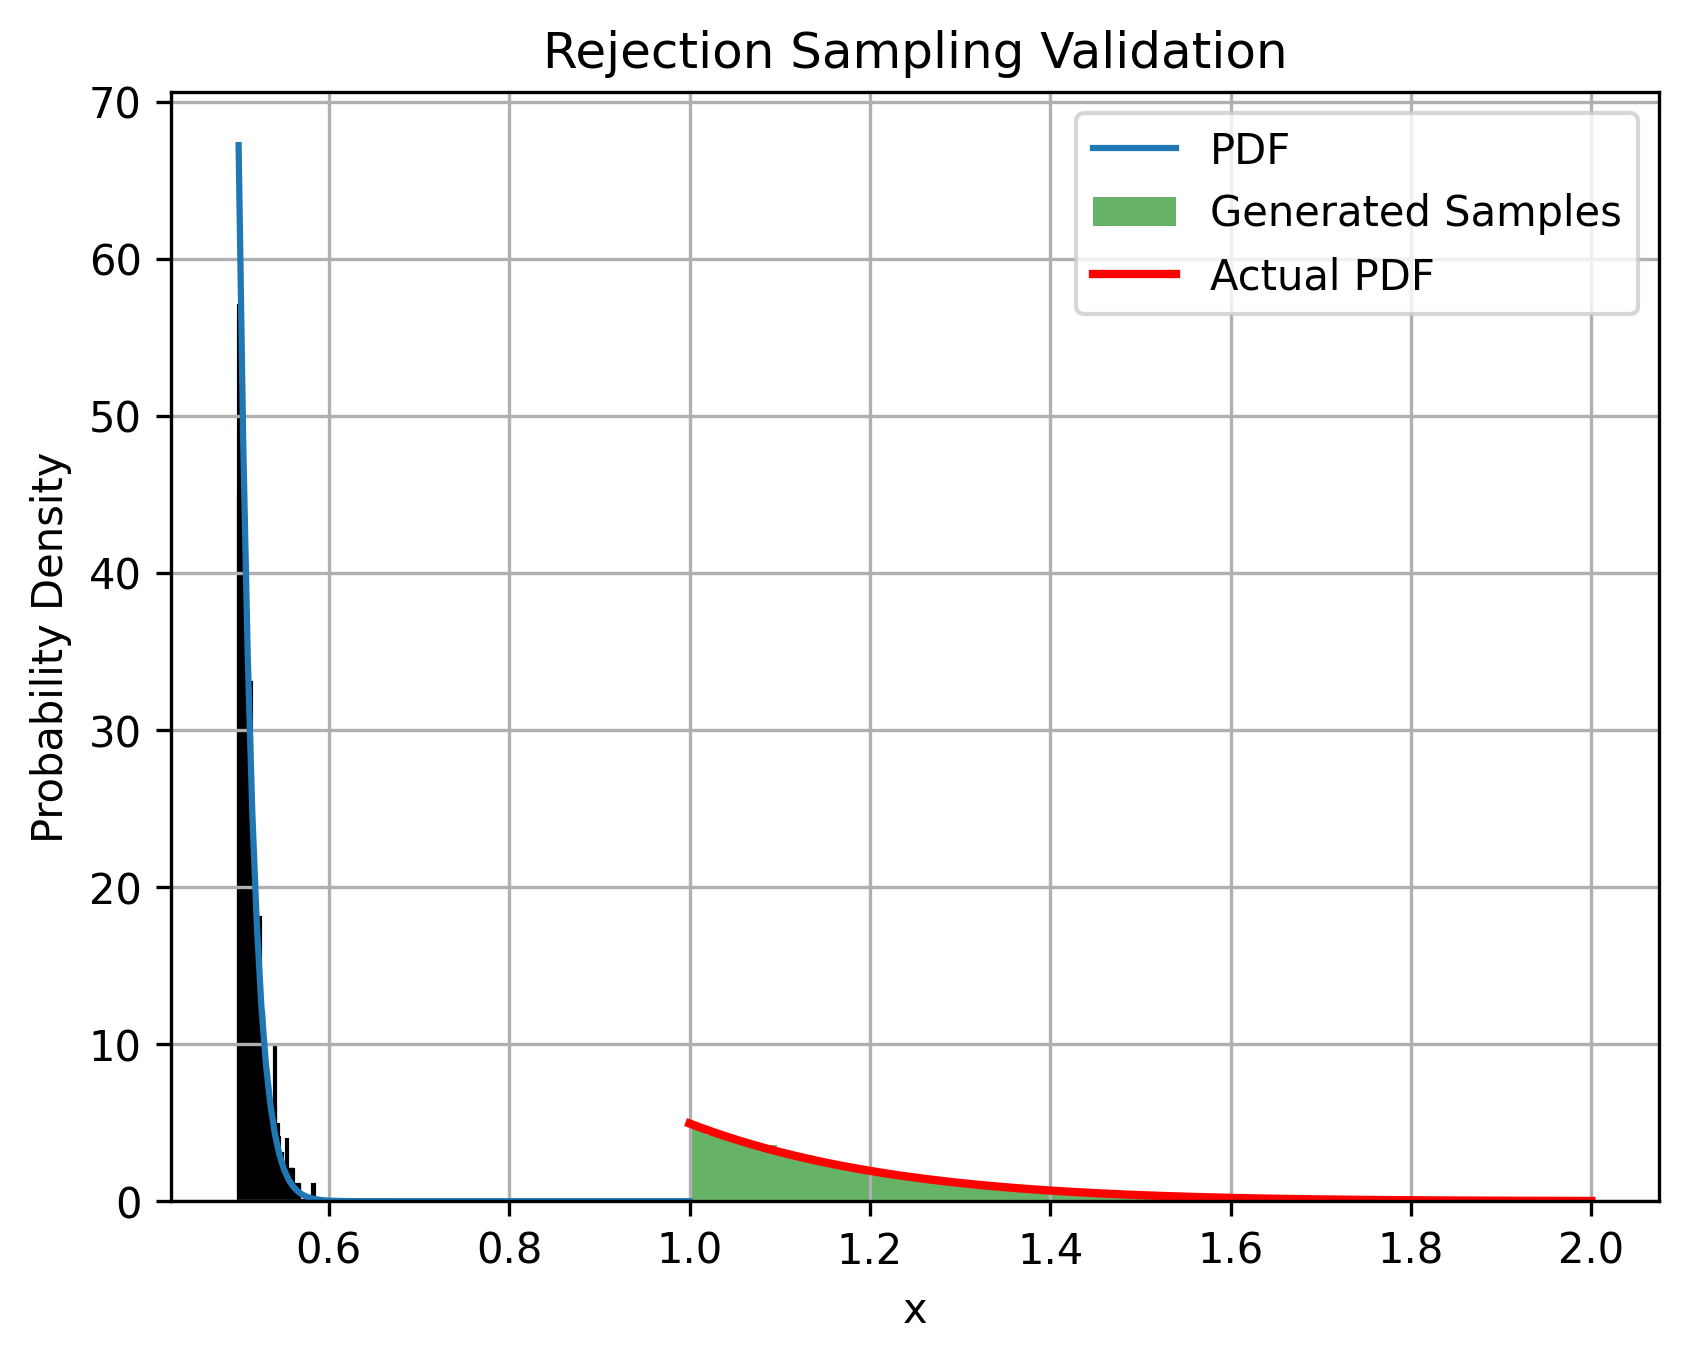

In [ ]:
def pdf_approx_n0(j, t, x0, r):
    return binom(j,2) / ( np.exp(-r * x0)) * np.exp(-binom(j,2) / ( np.exp(-r * x0)) * (t - x0)) + x0


#def pdf(x,j=6,x0=0.1,r=3):
#    return binom(j,2) * np.exp(r * x) * np.exp(-binom(j,2) / ( np.exp(-r * x0)) * (x - x0)) + x0

def pdf(x,j=6,x0=0.5,r=3):
    return binom(j,2) * np.exp(r * x) * np.exp(-binom(j,2) * (np.exp(r * x) - np.exp(r * x0)) / r )

#def pdf(E,a1=-.3,a2=73,a3=-18,A=33.8,Gamma=0.138,E0=0.9667):
#    return a1+a2*E+a3*E**2+A*(Gamma/(2*np.pi))/((E-E0)**2+(Gamma/2)**2)


x = np.linspace(0.5,1.0,100)
cdf = nbi_stat.eval_cdf(pdf,x)
o = nbi_stat.sample_pdf(np.random.random(1000),x,cdf)

h, b, w, e = nbi_stat.histogram(o,x)

plt.plot(x,pdf(x),label="PDF")
plt.hist(o, bins=100, edgecolor='black')

plt.legend()
plt.xlabel(r"$E$")

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

def pdf(x, j, x0, r):
    return binom(j, 2) * np.exp(r * x) * np.exp((-binom(j, 2) * (np.exp(r * x) - np.exp(r * x0))) / r)

def rejection_sampling(pdf, j, x0, r, n_samples=1):
    samples = []
    max_pdf = max(pdf(np.linspace(x0, x0+1, 1000), j, x0, r))  # Find the maximum value of the PDF in the sampling range
    while len(samples) < n_samples:
        # Generate a random sample from a uniform distribution within the domain where x > x0
        x_candidate = np.random.uniform(x0, x0+1)  # Adjust the range based on your PDF's domain

        # Generate a uniform random number between 0 and the maximum PDF value
        u = np.random.uniform(0, max_pdf)

        # Accept the sample if u is less than the PDF value at x_candidate
        if u < pdf(x_candidate, j, x0, r):
            samples.append(x_candidate)

    return np.array(samples)

# Parameters for the PDF
j = 3
x0 = 1
r = 0.5

# Generate random numbers from the PDF using rejection sampling
random_numbers = rejection_sampling(pdf, j, x0, r, n_samples=10000)

# Plotting the histogram of generated samples
plt.hist(random_numbers, bins=50, density=True, alpha=0.6, color='g', label='Generated Samples')

# Plot the actual PDF curve
x_values = np.linspace(x0, x0+1, 1000)  # Adjust the range based on your PDF's domain
plt.plot(x_values, pdf(x_values, j, x0, r), 'r-', linewidth=2, label='Actual PDF')

plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Rejection Sampling Validation')
plt.legend()
plt.grid(True)
plt.show()


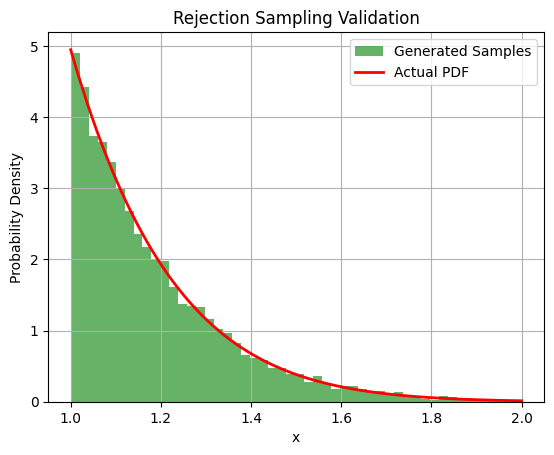

In [ ]:
rd_num=rejection_sampling(pdf, j, x0, r, n_samples=1)
print(rd_num[0])

1.220368373403789


In [ ]:
# def rand_time(j, x0, rin):
#     u = np.random.rand()
#     up=1-u
#     return np.log((-np.exp(rin * x0) * j + np.exp(rin * x0) * j**2 + 2 * rin * np.log(1 / (1 - up))) / ((-1 + j) * j)) / rin

# def rand_time_maple(j,x0,rin):
#   u = np.random.rand()
#   return np.log(-(np.log(1 - u) * rin - binom(j,2) * np.exp(rin * x0)) / binom(j,2)) / rin


# def pdf(x,j=6,x0=0.1,r=3):
#     return binom(j,2) * np.exp(r * x) * np.exp(-binom(j,2) * (np.exp(r * x) - np.exp(r * x0)) / r )

# x = np.linspace(0,3,1000)
# cdf = nbi_stat.eval_cdf(pdf,x)
# #print(cdf)
# o = nbi_stat.sample_pdf(np.random.random(1),x,cdf)
# print(o)


def sim_single_clade_exp(m,r):
  mwk = m
  tau = 0
  clusters = [1]*m #create cluster size
  cl = [clusters]
  time = [0]
  for i in range(m-1):
    dt = rejection_sampling(pdf, mwk, tau, r, n_samples=1)
    sam = sample(range(mwk),2) #pick two random lineages to coalesce
    clusters[sam[0]] = clusters[sam[0]]+clusters[sam[1]] #update cluster
    del clusters[sam[1]] #delete the other cluster that is not useful
    newc = clusters
    #tau = tau + dt[0]
    tau = dt[0]
    cl.append(newc[:])
    time.append(tau)
    mwk = mwk - 1
  out = {}
  k = 0
  for i in time:
    out[i] = cl[k]
    k = k + 1
  out[0] = [1]*m #force the first dic element to be all ones (don't know why)
  return(out)



def sim_exp(m,times,maxt,inc,r):
  t_list = np.linspace(0,maxt,inc)
  l = len(t_list)
  ini_list = [0]*m #get the number of list
  out = []
  for i in range(l):
    out.append(ini_list[:])

  for i in range(times):
    sim = sim_single_clade_exp(m,r)
    for j in range(l):
      val = rand_sample(sim,t_list[j])
      #print(val)
      #print(out[j])
      out[j][val-1] = out[j][val-1]+1
  return(out)

'\nplt.xlabel("Time")\nplt.ylabel("Probability")\n#plt.title("Validation - Single Clade, Exponential Growth Population Size (r=3)")\nplt.legend(handles=[line1,line3,line5,line7,line9,line11],loc=\'upper right\')\nplt.show()\n\n#plt.savefig(\'simulation_validation_exp.png\')\n\n'

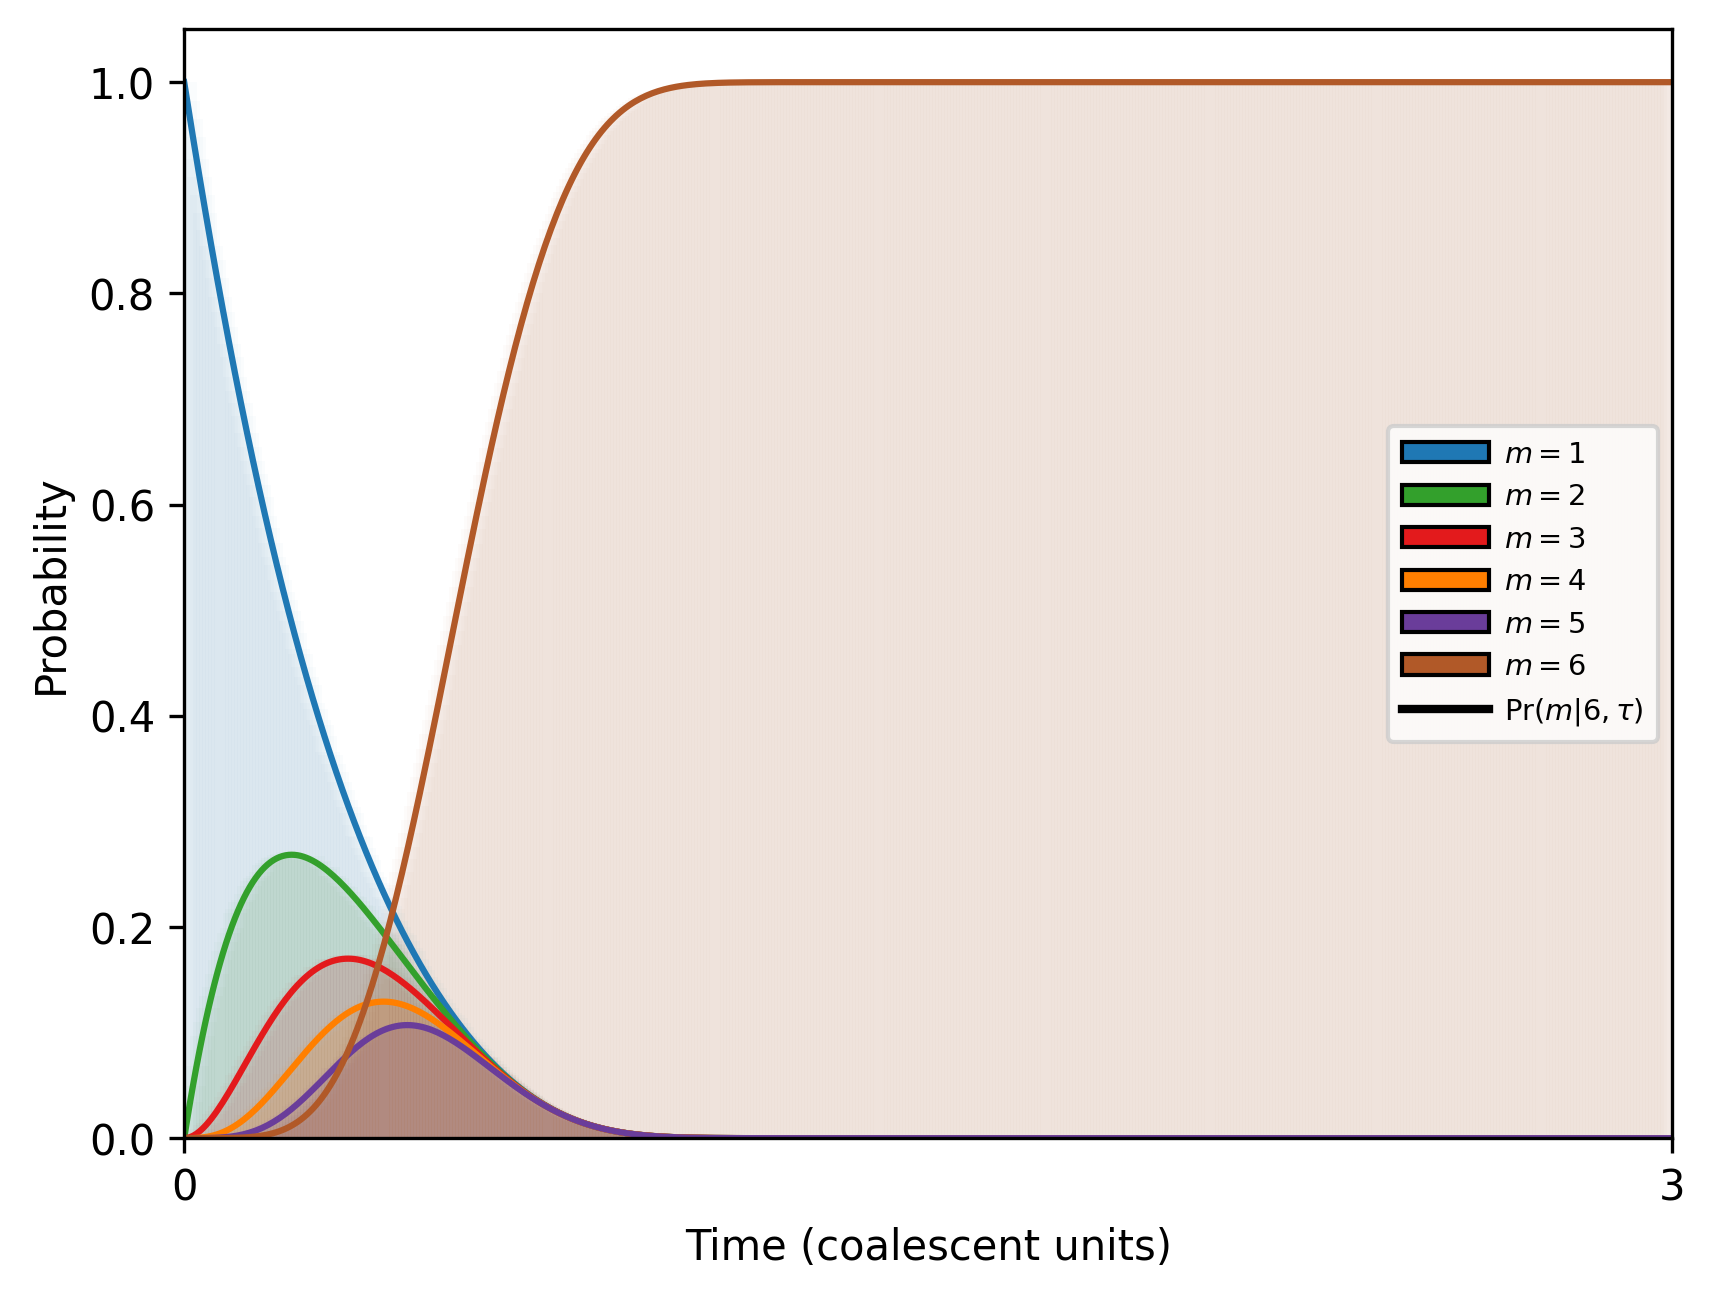

In [ ]:
#Plotting using python:
#check the closed form solution for finding a clade is correct (exp clade)
palette = sns.color_palette("Paired")

tt=sim_exp(6,50000,3,500,3)
c=convert_bar(tt)
#t_list = np.linspace(0,3,100)
#print(t_list)

gap = 1
ax = plt.gca()
for i, row in enumerate(c):
  #X = np.arange(len(row))
  t_list = np.linspace(0,3,500)
  plt.bar(t_list, list(map(lambda x: x/50000, row)),color=palette[i*2+1],
    width = 0.05,alpha=0.02)
  #plt.xticks(X + i * gap, t_list)
my_xticks = ax.get_xticks()
plt.xlim(0,3)
plt.xticks([my_xticks[1], my_xticks[-2]], visible=True, rotation="horizontal")

n=6
r=3
xlist=np.linspace(0,3,500)
ylist=[joint_pro_varying_pop(n,[1],r,t) for t in xlist]
line1,=plt.plot(xlist,ylist,color=palette[1],label='clade size 1')
ylist=[joint_pro_varying_pop(n,[2],r,t) for t in xlist]
line3,=plt.plot(xlist,ylist,color=palette[3],label='clade size 2')
ylist=[joint_pro_varying_pop(n,[3],r,t) for t in xlist]
line5,=plt.plot(xlist,ylist,color=palette[5],label='clade size 3')
ylist=[joint_pro_varying_pop(n,[4],r,t) for t in xlist]
line7,=plt.plot(xlist,ylist,color=palette[7],label='clade size 4')
ylist=[joint_pro_varying_pop(n,[5],r,t) for t in xlist]
line9,=plt.plot(xlist,ylist,color=palette[9],label='clade size 5')
ylist=[joint_pro_varying_pop(n,[6],r,t) for t in xlist]
line11,=plt.plot(xlist,ylist,color=palette[11],label='clade size 6')


plt.xlabel("Time (coalescent units)")
plt.ylabel("Probability")


color_legend_elements = [
    Patch(facecolor=palette[1], edgecolor='black', label='$m=1$'),
    Patch(facecolor=palette[3], edgecolor='black', label='$m=2$'),
    Patch(facecolor=palette[5], edgecolor='black', label='$m=3$'),
    Patch(facecolor=palette[7], edgecolor='black', label='$m=4$'),
    Patch(facecolor=palette[9], edgecolor='black', label='$m=5$'),
    Patch(facecolor=palette[11], edgecolor='black', label='$m=6$'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label=r'Pr$(m|6,\tau)$'),
]

plt.legend(handles=color_legend_elements, loc='center right',title_fontsize='small', fontsize='x-small', borderpad=0.5,
                         handletextpad=0.5, handlelength=3)

plt.savefig('simulation_validation_exp.png')

'''
plt.xlabel("Time")
plt.ylabel("Probability")
#plt.title("Validation - Single Clade, Exponential Growth Population Size (r=3)")
plt.legend(handles=[line1,line3,line5,line7,line9,line11],loc='upper right')
plt.show()

#plt.savefig('simulation_validation_exp.png')

'''

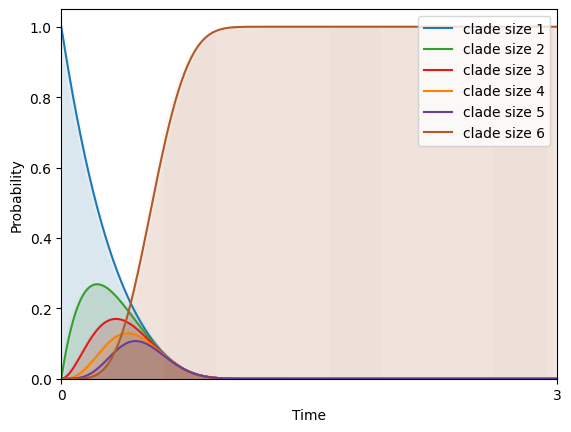

In [ ]:
#Plotting using python:
#check the closed form solution for finding a clade is correct (exp clade)
palette = sns.color_palette("Paired")

tt=sim_exp(6,50000,3,500,3)
c=convert_bar(tt)
#t_list = np.linspace(0,3,100)
#print(t_list)

gap = 1
ax = plt.gca()
for i, row in enumerate(c):
  #X = np.arange(len(row))
  t_list = np.linspace(0,3,500)
  plt.bar(t_list, list(map(lambda x: x/50000, row)),color=palette[i*2+1],
    width = 0.05,alpha=0.02)
  #plt.xticks(X + i * gap, t_list)
my_xticks = ax.get_xticks()
plt.xlim(0,3)
plt.xticks([my_xticks[1], my_xticks[-2]], visible=True, rotation="horizontal")

n=6
r=3
xlist=np.linspace(0,3,500)
ylist=[joint_pro_varying_pop_tavare(n,[1],r,t) for t in xlist]
line1,=plt.plot(xlist,ylist,color=palette[1],label='clade size 1')
ylist=[joint_pro_varying_pop_tavare(n,[2],r,t) for t in xlist]
line3,=plt.plot(xlist,ylist,color=palette[3],label='clade size 2')
ylist=[joint_pro_varying_pop_tavare(n,[3],r,t) for t in xlist]
line5,=plt.plot(xlist,ylist,color=palette[5],label='clade size 3')
ylist=[joint_pro_varying_pop_tavare(n,[4],r,t) for t in xlist]
line7,=plt.plot(xlist,ylist,color=palette[7],label='clade size 4')
ylist=[joint_pro_varying_pop_tavare(n,[5],r,t) for t in xlist]
line9,=plt.plot(xlist,ylist,color=palette[9],label='clade size 5')
ylist=[joint_pro_varying_pop_tavare(n,[6],r,t) for t in xlist]
line11,=plt.plot(xlist,ylist,color=palette[11],label='clade size 6')

plt.xlabel("Time")
plt.ylabel("Probability")
#plt.title("Validation - Single Clade, Exponential Growth Population Size (r=3)")
plt.legend(handles=[line1,line3,line5,line7,line9,line11],loc='upper right')
plt.show()

#plt.savefig('simulation_validation_exp.png')


# Main result

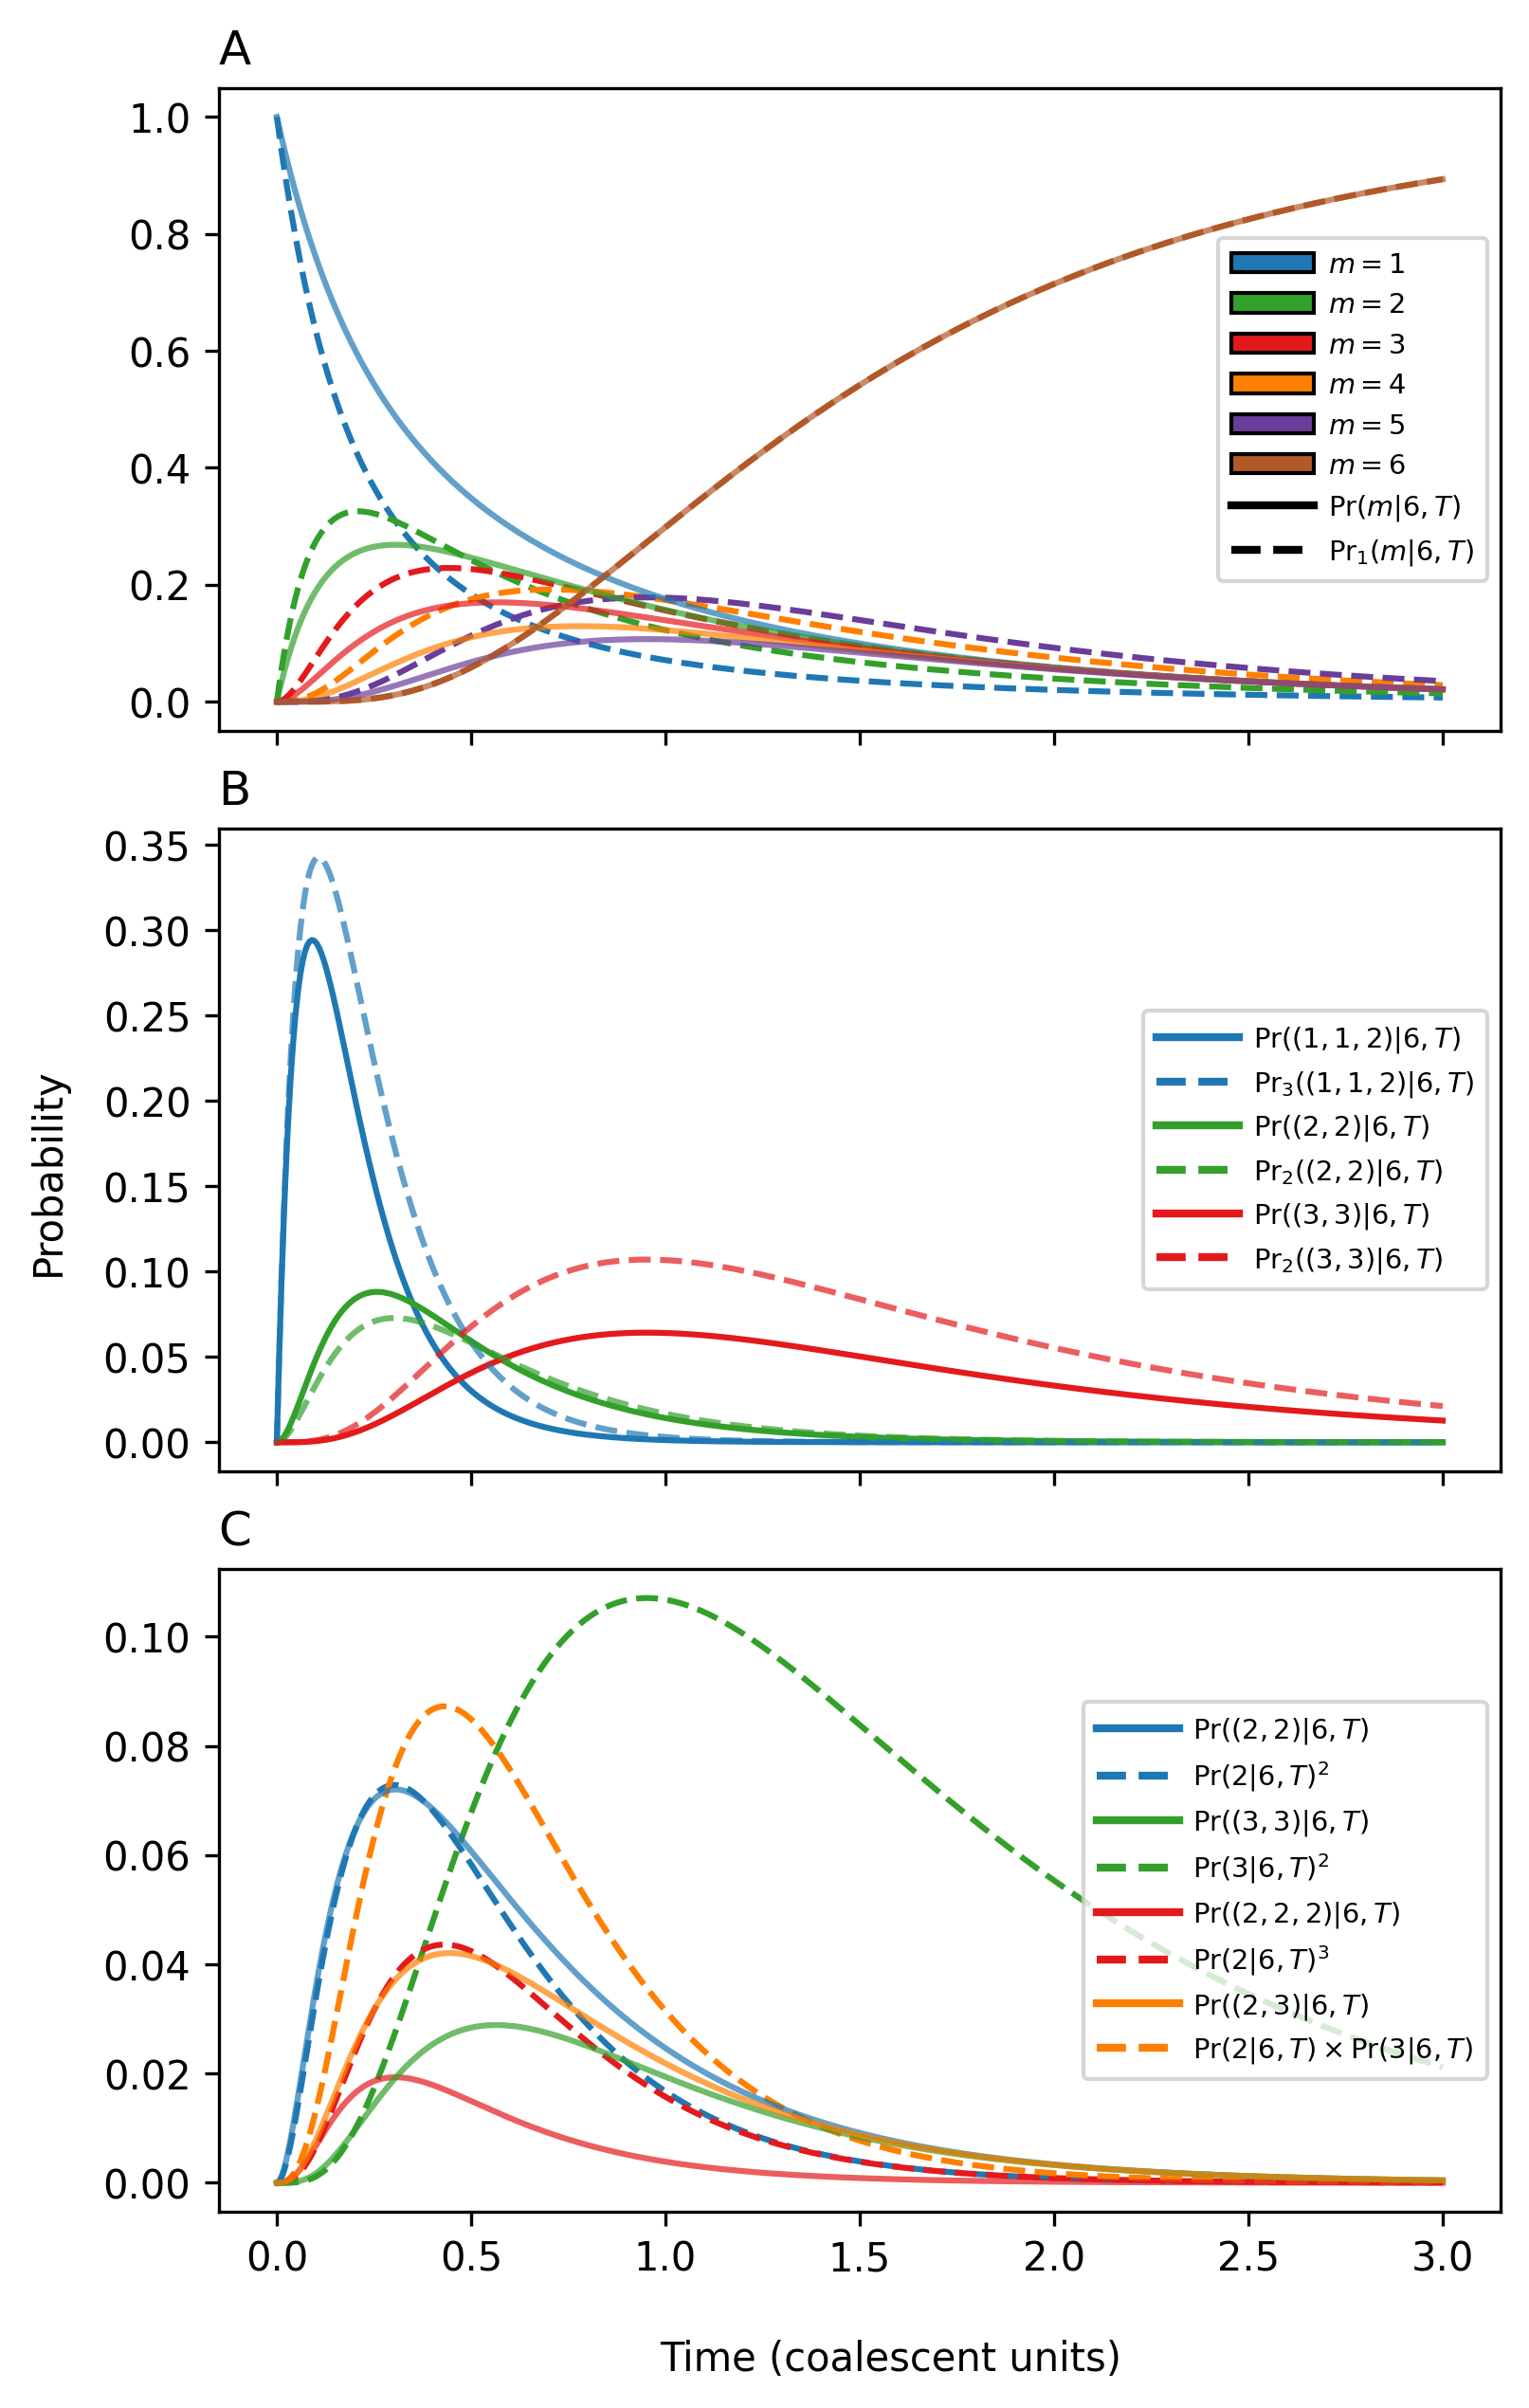

In [ ]:
palette = sns.color_palette("Paired")

fig, axs = plt.subplots(3, 1,layout='constrained',sharex=True,figsize=(5, 8))

n = 6
xlist=np.linspace(0,3,500)

# Single Individual vs single clade
ylist=[pro_ind(n,1,t) for t in xlist]
axs[0].plot(xlist,ylist,color=palette[1],linestyle='--',label='clade size 1')
ylist=[pro_ind(n,2,t) for t in xlist]
axs[0].plot(xlist,ylist,color=palette[3],linestyle='--',label='clade size 2')
ylist=[pro_ind(n,3,t) for t in xlist]
axs[0].plot(xlist,ylist,color=palette[5],linestyle='--',label='clade size 3')
ylist=[pro_ind(n,4,t) for t in xlist]
axs[0].plot(xlist,ylist,color=palette[7],linestyle='--',label='clade size 4')
ylist=[pro_ind(n,5,t) for t in xlist]
axs[0].plot(xlist,ylist,color=palette[9],linestyle='--',label='clade size 5')
ylist=[pro_ind(n,6,t) for t in xlist]
axs[0].plot(xlist,ylist,color=palette[11],linestyle='--',label='clade size 6')
# adding the clade for comparison
ylist=[joint_pro(n,[1],t) for t in xlist]
axs[0].plot(xlist,ylist,color=palette[1],alpha = 0.7)
ylist=[joint_pro(n,[2],t) for t in xlist]
axs[0].plot(xlist,ylist,color=palette[3],alpha = 0.7)
ylist=[joint_pro(n,[3],t) for t in xlist]
axs[0].plot(xlist,ylist,color=palette[5],alpha = 0.7)
ylist=[joint_pro(n,[4],t) for t in xlist]
axs[0].plot(xlist,ylist,color=palette[7],alpha = 0.7)
ylist=[joint_pro(n,[5],t) for t in xlist]
axs[0].plot(xlist,ylist,color=palette[9],alpha = 0.7)
ylist=[joint_pro(n,[6],t) for t in xlist]
axs[0].plot(xlist,ylist,color=palette[11],alpha = 0.7)
axs[0].set_title('A',loc='left')
#axs[0].legend(fontsize="7",loc="upper right",framealpha=0.3)

color_legend_elements = [
    Patch(facecolor=palette[1], edgecolor='black', label='$m=1$'),
    Patch(facecolor=palette[3], edgecolor='black', label='$m=2$'),
    Patch(facecolor=palette[5], edgecolor='black', label='$m=3$'),
    Patch(facecolor=palette[7], edgecolor='black', label='$m=4$'),
    Patch(facecolor=palette[9], edgecolor='black', label='$m=5$'),
    Patch(facecolor=palette[11], edgecolor='black', label='$m=6$'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label=r'Pr$(m|6,T)$'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label=r'Pr$_1(m|6,T)$')
]
axs[0].legend(handles=color_legend_elements, loc='center right',title_fontsize='small', fontsize='x-small', borderpad=0.5,
                         handletextpad=0.5, handlelength=3)



# Multiple Clades

ylist=[joint_pro(n,[2,2],t) for t in xlist]
axs[2].plot(xlist,ylist,color=palette[1],linestyle='--',label='clade size (2,2)')
ylist=[joint_pro(n,[3,3],t) for t in xlist]
axs[2].plot(xlist,ylist,color=palette[3],linestyle='--',label='clade size (3,3)')
ylist=[joint_pro(n,[2,2,2],t) for t in xlist]
axs[2].plot(xlist,ylist,color=palette[5],linestyle='--',label='clade size (3,3)')
ylist=[joint_pro(n,[2,3],t) for t in xlist]
axs[2].plot(xlist,ylist,color=palette[7],linestyle='--',label='clade size (3,3)')


ylist=[joint_pro(n,[2],t)*joint_pro(n,[2],t)*joint_pro(n,[2],t) for t in xlist]
axs[2].plot(xlist,ylist,color=palette[5],label='clade size 1',alpha = 0.7)
ylist=[joint_pro(n,[2],t)*joint_pro(n,[2],t) for t in xlist]
axs[2].plot(xlist,ylist,color=palette[1],label='clade size 2',alpha = 0.7)
ylist=[joint_pro(n,[3],t)*joint_pro(n,[3],t) for t in xlist]
axs[2].plot(xlist,ylist,color=palette[3],label='clade size 3',alpha = 0.7)
ylist=[joint_pro(n,[2],t)*joint_pro(n,[3],t) for t in xlist]
axs[2].plot(xlist,ylist,color=palette[7],label='clade size 3',alpha = 0.7)

axs[2].set_title('C',loc='left')
#axs[1].legend(fontsize="7",loc="upper right",framealpha=0.5)
color_legend_elements = [
    Line2D([0], [0], color=palette[1], lw=2, linestyle='-', label=r'Pr$((2,2)|6,T)$'),
    Line2D([0], [0], color=palette[1], lw=2, linestyle='--', label=r'Pr$(2|6,T)^2$'),
    Line2D([0], [0], color=palette[3], lw=2, linestyle='-', label=r'Pr$((3,3)|6,T)$'),
    Line2D([0], [0], color=palette[3], lw=2, linestyle='--', label=r'Pr$(3|6,T)^2$'),
    Line2D([0], [0], color=palette[5], lw=2, linestyle='-', label=r'Pr$((2,2,2)|6,T)$'),
    Line2D([0], [0], color=palette[5], lw=2, linestyle='--', label=r'Pr$(2|6,T)^3$'),
    Line2D([0], [0], color=palette[7], lw=2, linestyle='-', label=r'Pr$((2,3)|6,T)$'),
    Line2D([0], [0], color=palette[7], lw=2, linestyle='--', label=r'Pr$(2|6,T) \times$Pr$(3|6,T)$')
]
axs[2].legend(handles=color_legend_elements, loc='center right',title_fontsize='small', fontsize='x-small', borderpad=0.5,
                         handletextpad=0.5, handlelength=3)





# Multiple Indviduals
ylist=[joint_pro_ind(n,3,[1,1,2],t) for t in xlist]
axs[1].plot(xlist,ylist,color=palette[1],label='2 lineages in clade (1,4)')
ylist=[joint_pro_ind(n,2,[2,2],t) for t in xlist]
axs[1].plot(xlist,ylist,color=palette[3],label='2 lineages in clade (2,2)')
ylist=[joint_pro_ind(n,2,[3,3],t) for t in xlist]
axs[1].plot(xlist,ylist,color=palette[5],label='2 lineages in clade (3,3)')
# adding multi-clades

ylist=[joint_pro(n,[1,1,2],t) for t in xlist]
axs[1].plot(xlist,ylist,color=palette[1],linestyle='--',label='clade size (1,4)',alpha = 0.7)
ylist=[joint_pro(n,[2,2],t) for t in xlist]
axs[1].plot(xlist,ylist,color=palette[3],linestyle='--',label='clade size (2,2)',alpha = 0.7)
ylist=[joint_pro(n,[3,3],t) for t in xlist]
axs[1].plot(xlist,ylist,color=palette[5],linestyle='--',label='clade size (3,3)',alpha = 0.7)
axs[1].set_title('B',loc='left')
#axs[2].legend(fontsize="7",loc="upper right",framealpha=0.5)
color_legend_elements = [
    Line2D([0], [0], color=palette[1], lw=2, linestyle='-', label=r'Pr$((1,1,2)|6,T)$'),
    Line2D([0], [0], color=palette[1], lw=2, linestyle='--', label=r'Pr$_{3}((1,1,2)|6,T)$'),
    Line2D([0], [0], color=palette[3], lw=2, linestyle='-', label=r'Pr$((2,2)|6,T)$'),
    Line2D([0], [0], color=palette[3], lw=2, linestyle='--', label=r'Pr$_{2}((2,2)|6,T)$'),
    Line2D([0], [0], color=palette[5], lw=2, linestyle='-', label=r'Pr$((3,3)|6,T)$'),
    Line2D([0], [0], color=palette[5], lw=2, linestyle='--', label=r'Pr$_{2}((3,3)|6,T)$')
]
axs[1].legend(handles=color_legend_elements, loc='center right',title_fontsize='small', fontsize='x-small', borderpad=0.5,
                         handletextpad=0.5, handlelength=3)

#fig.text(0.5, -0.03, 'Probability of the focal clade at time T', ha='center')
#fig.text(-0.03, 0.5, 'Time (coalescent units)', va='center', rotation='vertical')
fig.text(-0.03, 0.45, 'Probability', ha='center',rotation='vertical')
fig.text(0.4, -0.03, 'Time (coalescent units)', va='center')

for ax in axs.flat:
    ax.label_outer()

#handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels,fontsize="5", loc='upper right')

plt.savefig('filename.jpg',bbox_inches='tight')



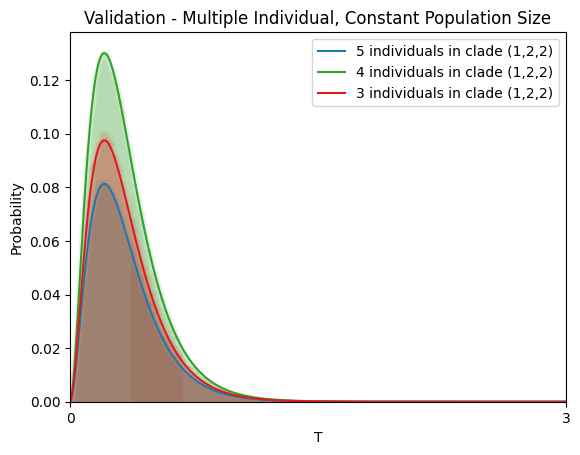

In [ ]:
#Plotting using python:
#check this is correct! (multiple individuals done)
#check the closed form solution for finding a clade is correct
palette = sns.color_palette("Paired")

tt=sim_i_multi(6,5,[1,2,2],50000,3,500)
merged = list(itertools.chain.from_iterable(tt))
gap = 1
ax = plt.gca()
t_list = np.linspace(0,3,500)
plt.bar(t_list,list(map(lambda x: x/50000,merged)),color=palette[1],width = 0.05, alpha=0.05)
my_xticks = ax.get_xticks()
plt.xlim(0,3)
plt.xticks([my_xticks[1], my_xticks[-2]], visible=True, rotation="horizontal")


tt2=sim_i_multi(6,4,[1,2,2],50000,3,500)
merged = list(itertools.chain.from_iterable(tt2))
gap = 1
ax = plt.gca()
t_list = np.linspace(0,3,500)
plt.bar(t_list,list(map(lambda x: x/50000,merged)),color=palette[3],width = 0.05, alpha=0.05)
my_xticks = ax.get_xticks()
plt.xlim(0,3)
plt.xticks([my_xticks[1], my_xticks[-2]], visible=True, rotation="horizontal")


tt3=sim_i_multi(6,3,[1,2,2],50000,3,500)
merged = list(itertools.chain.from_iterable(tt3))
gap = 1
ax = plt.gca()
t_list = np.linspace(0,3,500)
plt.bar(t_list,list(map(lambda x: x/50000,merged)),color=palette[5],width = 0.05, alpha=0.05)
my_xticks = ax.get_xticks()
plt.xlim(0,3)
plt.xticks([my_xticks[1], my_xticks[-2]], visible=True, rotation="horizontal")


n=6
xlist=np.linspace(0,3,500)
ylist=[joint_pro_ind(n,5,[1,2,2],t) for t in xlist]
line1,=plt.plot(xlist,ylist,color=palette[1],label='5 individuals in clade (1,2,2)')

ylist=[joint_pro_ind(n,4,[1,2,2],t) for t in xlist]
line2,=plt.plot(xlist,ylist,color=palette[3],label='4 individuals in clade (1,2,2)')

ylist=[joint_pro_ind(n,3,[1,2,2],t) for t in xlist]
line3,=plt.plot(xlist,ylist,color=palette[5],label='3 individuals in clade (1,2,2)')

plt.xlabel("T")
plt.ylabel("Probability")
plt.title("Validation - Multiple Individual, Constant Population Size")
plt.legend(handles=[line1,line2,line3])
#plt.show()
plt.savefig('validation_mul_ind_less_than.png')

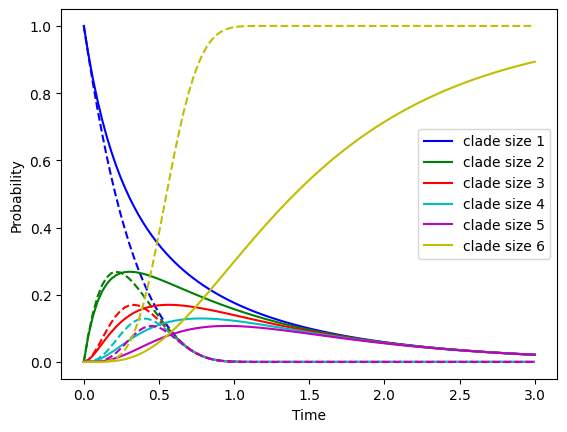

In [ ]:
# We can also find the joint probability
n=6
r=3
xlist=np.linspace(0,3,100)
ylist=[joint_pro(n,[1],t) for t in xlist]
line1,=plt.plot(xlist,ylist,'b',label='clade size 1')
ylist=[joint_pro_varying_pop(n,[1],r,t) for t in xlist]
line2,=plt.plot(xlist,ylist,'b--')
ylist=[joint_pro(n,[2],t) for t in xlist]
line3,=plt.plot(xlist,ylist,'g',label='clade size 2')
ylist=[joint_pro_varying_pop(n,[2],r,t) for t in xlist]
line4,=plt.plot(xlist,ylist,'g--')
ylist=[joint_pro(n,[3],t) for t in xlist]
line5,=plt.plot(xlist,ylist,'r',label='clade size 3')
ylist=[joint_pro_varying_pop(n,[3],r,t) for t in xlist]
line6,=plt.plot(xlist,ylist,'r--')
ylist=[joint_pro(n,[4],t) for t in xlist]
line7,=plt.plot(xlist,ylist,'c',label='clade size 4')
ylist=[joint_pro_varying_pop(n,[4],r,t) for t in xlist]
line8,=plt.plot(xlist,ylist,'c--')
ylist=[joint_pro(n,[5],t) for t in xlist]
line9,=plt.plot(xlist,ylist,'m',label='clade size 5')
ylist=[joint_pro_varying_pop(n,[5],r,t) for t in xlist]
line10,=plt.plot(xlist,ylist,'m--')
ylist=[joint_pro(n,[6],t) for t in xlist]
line11,=plt.plot(xlist,ylist,'y',label='clade size 6')
ylist=[joint_pro_varying_pop(n,[6],r,t) for t in xlist]
line12,=plt.plot(xlist,ylist,'y--')
plt.xlabel("Time")
plt.ylabel("Probability")
#plt.title("Comparison between constant population (solid) and \n exponentially increased population (dashed, growth rate = 3)")
plt.legend(handles=[line1,line3,line5,line7,line9,line11])

plt.savefig('joint_clade_size.png')



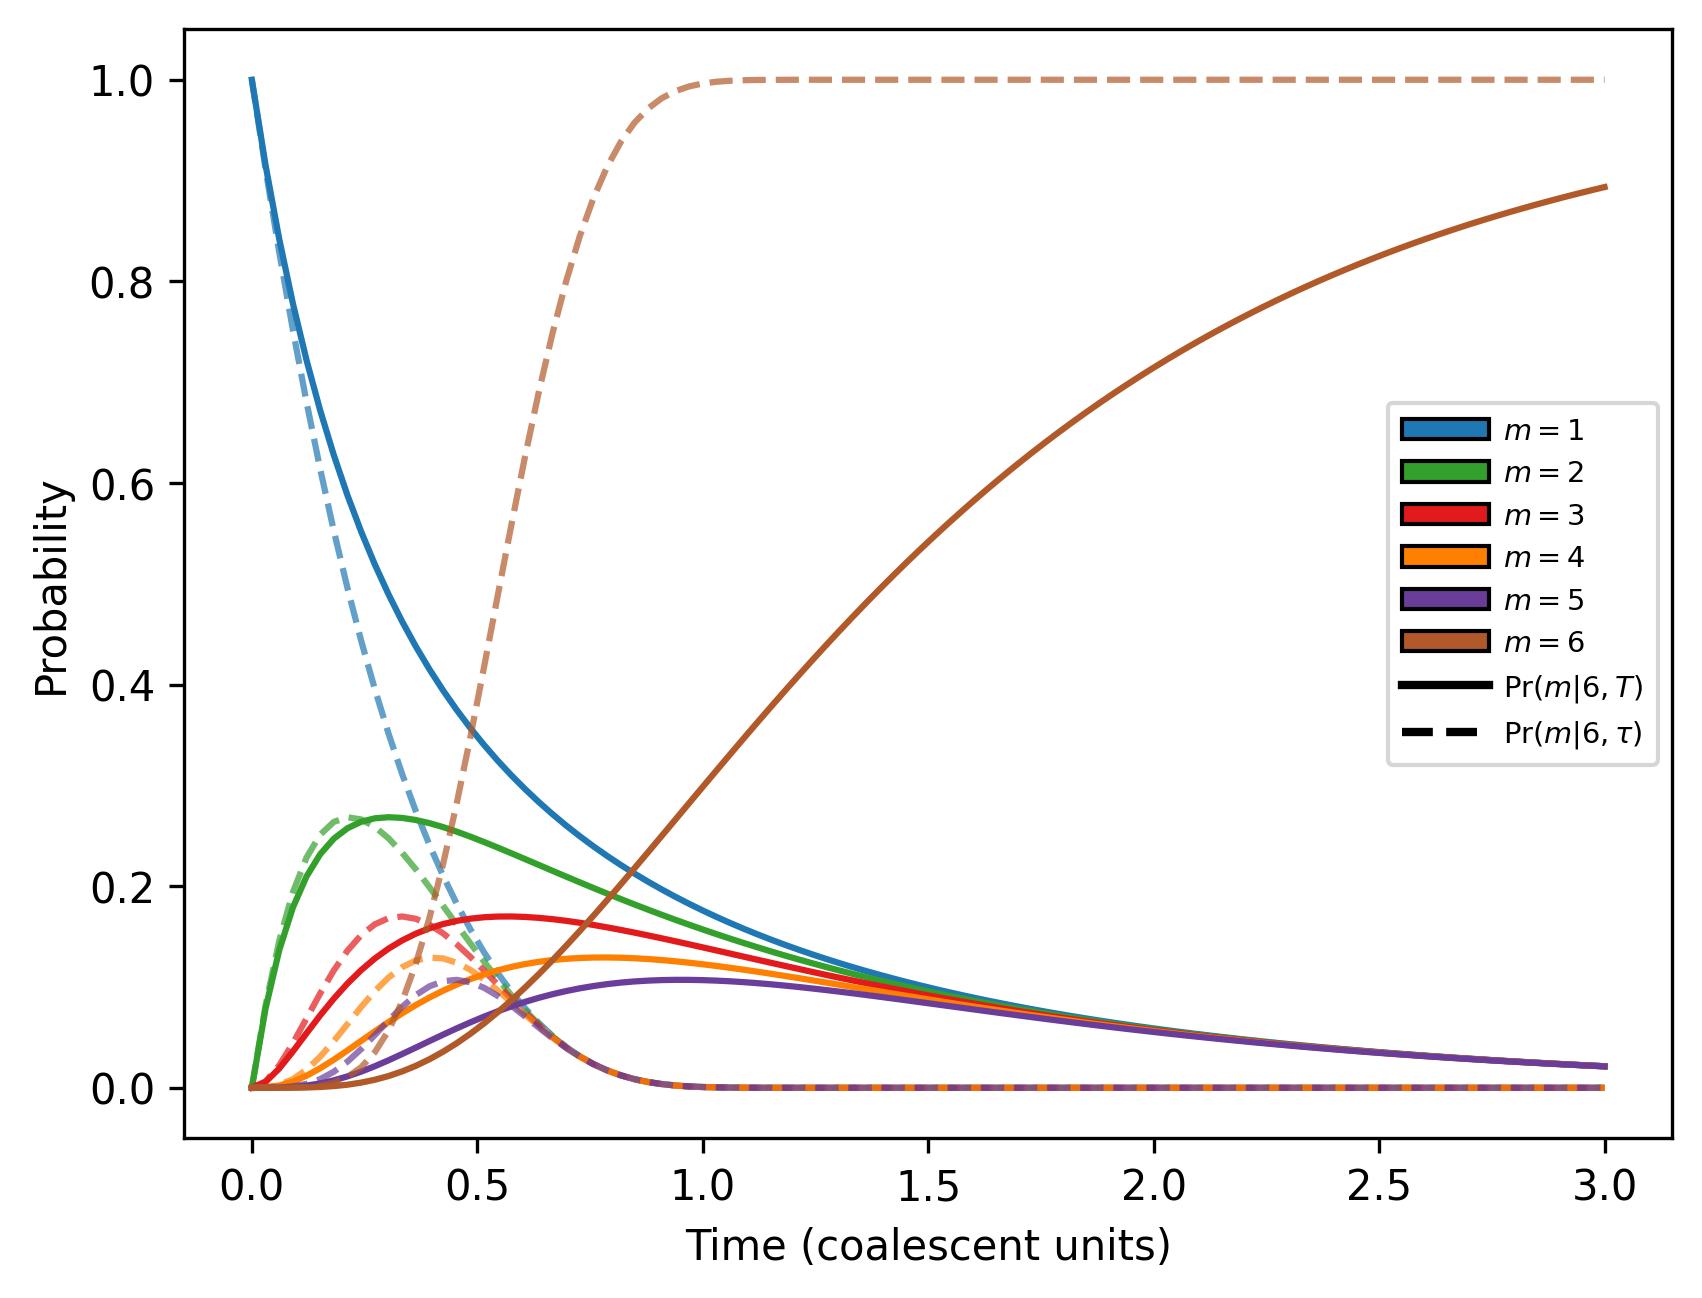

In [ ]:
# We can also find the joint probability
palette = sns.color_palette("Paired")

n=6
r=3
xlist=np.linspace(0,3,100)
ylist=[joint_pro(n,[1],t) for t in xlist]
line1,=plt.plot(xlist,ylist,color=palette[1],label='clade size 1')
ylist=[joint_pro_varying_pop(n,[1],r,t) for t in xlist]
line2,=plt.plot(xlist,ylist,color=palette[1],linestyle='--',alpha=0.7)
ylist=[joint_pro(n,[2],t) for t in xlist]
line3,=plt.plot(xlist,ylist,color=palette[3],label='clade size 2')
ylist=[joint_pro_varying_pop(n,[2],r,t) for t in xlist]
line4,=plt.plot(xlist,ylist,color=palette[3],linestyle='--',alpha=0.7)
ylist=[joint_pro(n,[3],t) for t in xlist]
line5,=plt.plot(xlist,ylist,color=palette[5],label='clade size 3')
ylist=[joint_pro_varying_pop(n,[3],r,t) for t in xlist]
line6,=plt.plot(xlist,ylist,color=palette[5],linestyle='--',alpha=0.7)
ylist=[joint_pro(n,[4],t) for t in xlist]
line7,=plt.plot(xlist,ylist,color=palette[7],label='clade size 4')
ylist=[joint_pro_varying_pop(n,[4],r,t) for t in xlist]
line8,=plt.plot(xlist,ylist,color=palette[7],linestyle='--',alpha=0.7)
ylist=[joint_pro(n,[5],t) for t in xlist]
line9,=plt.plot(xlist,ylist,color=palette[9],label='clade size 5')
ylist=[joint_pro_varying_pop(n,[5],r,t) for t in xlist]
line10,=plt.plot(xlist,ylist,color=palette[9],linestyle='--',alpha=0.7)
ylist=[joint_pro(n,[6],t) for t in xlist]
line11,=plt.plot(xlist,ylist,color=palette[11],label='clade size 6')
ylist=[joint_pro_varying_pop(n,[6],r,t) for t in xlist]
line12,=plt.plot(xlist,ylist,color=palette[11],linestyle='--',alpha=0.7)
plt.xlabel("Time (coalescent units)")
plt.ylabel("Probability")


color_legend_elements = [
    Patch(facecolor=palette[1], edgecolor='black', label='$m=1$'),
    Patch(facecolor=palette[3], edgecolor='black', label='$m=2$'),
    Patch(facecolor=palette[5], edgecolor='black', label='$m=3$'),
    Patch(facecolor=palette[7], edgecolor='black', label='$m=4$'),
    Patch(facecolor=palette[9], edgecolor='black', label='$m=5$'),
    Patch(facecolor=palette[11], edgecolor='black', label='$m=6$'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label=r'Pr$(m|6,T)$'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label=r'Pr$(m|6,\tau)$')
]

# Create custom legend handles for line styles
line_legend_elements = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', label='Clade Size'),
    Line2D([0], [0], color='black', lw=1, linestyle=(0, (5, 5)), label='Individual Size')
]

plt.legend(handles=color_legend_elements, loc='center right',title_fontsize='small', fontsize='x-small', borderpad=0.5,
                         handletextpad=0.5, handlelength=3)


#plt.legend(handles=line_legend_elements, loc='lower right', title='Size Type')
#line1.add_artist(line1.legend(handles=line_legend_elements, loc='lower right', title='Size Type'))


#plt.title("Comparison between constant population (solid) and \n exponentially increased population (dashed, growth rate = 3)")
#plt.legend(handles=[line1,line3,line5,line7,line9,line11])

plt.savefig('exp_constant.png')

In [ ]:
def pentagonal_number(k):
    return int(k*(3*k-1) / 2)

def compute_partitions(goal):
    partitions = [1]
    for n in range(1,goal+1):
        partitions.append(0)
        for k in range(1,n+1):
            coeff = (-1)**(k+1)
            for t in [pentagonal_number(k), pentagonal_number(-k)]:
                if (n-t) >= 0:
                    partitions[n] = partitions[n] + coeff*partitions[n-t]
    return partitions

compute_partitions(80)[-1]

15796476